# **Style over substance:** Fine-tuning embeddings to decompose authorial style in the Hebrew Bible

**This project was completed as part of CS109b: Advanced Topics in Data Science at Harvard IACS**
May, 2021

Topic A: Ancient Texts

# Problem Statement

**An interwoven text**

It has been traditionally believed that the Hebrew Bible is a composite text woven from several seperate sources. Using literary analysis, Biblical scholars have identified differences in style between several seperate sections of text. 

**The Documentary Hypothesis**

Recently scholars have come to a disagreement over the validity of a previously widely held view on the authorial origins of the Hebrew Bible: the 'Documentary Hypothesis'. This is the traditional argument that the Hebrew Bible is made up of sections written by five seperate sources (called J, E, P, D and R in the literature). However, since 2011 several scholars have used data science and statistical methods to interrogate this view. 

**Text Representation**

There are two critical aspects to the challenge of author decomposition for this text. The first is creating a representation of the the text that can accurately encode stylistic features. This is a particularly difficult problem because we do not know the number of authors of the text, and therefore we do not know how many styles are in the text. 

**Unsupervised**

A second layer of challenge is the fact that we do not know for sure whether any part of the Hebrew Bible comes from a specific source. Therefore we do not have labels to train a classifier. If we assume certain books were written by certain sources this may not help us to decompose authorship in a principled manner. However, while we do not know for sure the authors of the text, we do know which genre different parts of the Hebrew Bible are written in. For example, poetry books are of a different genre from prophetic books. Therefore, we can use the differences in genre as some handle on whether our model is able to effectively disentangle different styles.

**Contents of Notebook** 

Section 1: Data Preprocessing

Section 2: Exploratory Data Analysis

Section 3: Exploring and Encoding Stylistic Features

Section 4: Baseline Model and Performance on Composite Texts

Section 5: Fine-Tuning BERT

Section 6: Constructing the Full Model

Section 7: Selecting the Number of Cluster (number of authors)

Section 8: Interpreting Full Model Clusters

Section 9: Testing Full Model on Composite Texts

Section 10: Final Model Predictions on Full Hebrew Bible

Section 11: Discussion and Next Steps

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import string
import re
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# NLTK
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split


# import the necessary libraries
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' #Trying to reduce tensorflow warnings
import re
import math
import string

import time
import json
import random
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# useful structures and functions for experiments 
from time import sleep
from collections import Counter
from collections import defaultdict
from glob import glob

# specific machine learning functionality
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization, RepeatVector
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import the necessary libraries
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL']='2' #Trying to reduce tensorflow warnings
import re
import math
import string
#import hw_utils # LOADS HW CODE (helps de-clutter this notebook)
import time
import json
import random
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# useful structures and functions for experiments 
from time import sleep
from collections import Counter
from collections import defaultdict
from glob import glob

# specific machine learning functionality
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization, RepeatVector
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
#TF Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization, RepeatVector

In [ ]:
# download nltk's punkt sentence tokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.4.1
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Section 1: Data Preprocessing

**Load Data**

We load both a Hebrew script file and the translated King James version (just for interepretation). All model fitting will be done on the Hebrew script.

In [ ]:
# Upload file
from google.colab import files
uploaded = files.upload()

Saving uwtt.txt to uwtt.txt


In [ ]:
# Function to help separate text from verse and chapter labels
def splitlabels(stringy, setting = False):

    #isolate book
    book = stringy[:3]

    #text to parse
    to_parse = stringy[5:]

    verse_number = ""
    text = ""

    #loop through and delineate
    for char in to_parse:
        if char.isdigit() or char == ':':
            verse_number += char

        else:
            text += char

    #get rid of extra space
    text = text[1:]

    if setting:
      return book, verse_number, text
    
    else:
      return text

In [ ]:
# We load the Hebrew Data file. It should be noted that we do have an English file, but it has a different selection from the Hebrew file therefore we will
# directly translate the Hebrew into English ourselves. Secondly, we were also given a unicode version of the original text but decided that it was better to use the 
# original Hebrew text because we are able to use embeddings to encode the original Hebrew.

hebrew_script_filename = 'uwtt.txt'
hebrew_script_data = pd.read_csv(hebrew_script_filename,delimiter='\r\n', header=None, names=["all_text"])

hebrew_script_data['label'] = hebrew_script_data['all_text'].str[:8]
hebrew_script_data['book'] = hebrew_script_data['all_text'].str[:3]
hebrew_script_data['text'] = hebrew_script_data['all_text'].apply(splitlabels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
# import king james
from google.colab import files
english_script_file = files.upload()

Saving kjv.txt to kjv.txt


In [ ]:
english_script_filename = 'kjv.txt'

In [ ]:
english_data = pd.read_csv(english_script_filename,delimiter='\r\n', header=None, names=["all_text"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
english_data['label'] = english_data['all_text'].str[:8]
english_data['book'] = english_data['all_text'].str[:3]
english_data['text'] = english_data['all_text'].apply(splitlabels)

In [ ]:
english_data.head(10)

,all_text,label,book,text
0,Gen 1:1 In the beginning God created the heave...,Gen 1:1,Gen,In the beginning God created the heaven and th...
1,"Gen 1:2 And the earth was without form, and vo...",Gen 1:2,Gen,"And the earth was without form, and void; and ..."
2,"Gen 1:3 And God said, Let there be light: and ...",Gen 1:3,Gen,"And God said, Let there be light and there was..."
3,"Gen 1:4 And God saw the light, that [it was] g...",Gen 1:4,Gen,"And God saw the light, that [it was] good and ..."
4,"Gen 1:5 And God called the light Day, and the ...",Gen 1:5,Gen,"And God called the light Day, and the darkness..."
5,"Gen 1:6 And God said, Let there be a firmament...",Gen 1:6,Gen,"And God said, Let there be a firmament in the ..."
6,"Gen 1:7 And God made the firmament, and divide...",Gen 1:7,Gen,"And God made the firmament, and divided the wa..."
7,Gen 1:8 And God called the firmament Heaven. A...,Gen 1:8,Gen,And God called the firmament Heaven. And the e...
8,"Gen 1:9 And God said, Let the waters under the...",Gen 1:9,Gen,"And God said, Let the waters under the heaven ..."
9,Gen 1:10 And God called the dry [land] Earth; ...,Gen 1:10,Gen,And God called the dry [land] Earth; and the g...


In [ ]:
hebrew_script_data.head(10)

,all_text,label,book,text
0,Gen 1:1 בראשית ברא אלהים את השמים ואת הארץ,Gen 1:1,Gen,בראשית ברא אלהים את השמים ואת הארץ
1,Gen 1:2 והארץ היתה תהו ובהו וחשך על־פני תהום ו...,Gen 1:2,Gen,והארץ היתה תהו ובהו וחשך על־פני תהום ורוח אלהי...
2,Gen 1:3 ויאמר אלהים יהי אור ויהי־אור,Gen 1:3,Gen,ויאמר אלהים יהי אור ויהי־אור
3,Gen 1:4 וירא אלהים את־האור כי־טוב ויבדל אלהים ...,Gen 1:4,Gen,וירא אלהים את־האור כי־טוב ויבדל אלהים בין האור...
4,Gen 1:5 ויקרא אלהים לאור יום ולחשך קרא לילה וי...,Gen 1:5,Gen,ויקרא אלהים לאור יום ולחשך קרא לילה ויהי־ערב ו...
5,Gen 1:6 ויאמר אלהים יהי רקיע בתוך המים ויהי מב...,Gen 1:6,Gen,ויאמר אלהים יהי רקיע בתוך המים ויהי מבדיל בין ...
6,Gen 1:7 ויעש אלהים את־הרקיע ויבדל בין המים אשר...,Gen 1:7,Gen,ויעש אלהים את־הרקיע ויבדל בין המים אשר מתחת לר...
7,Gen 1:8 ויקרא אלהים לרקיע שמים ויהי־ערב ויהי־ב...,Gen 1:8,Gen,ויקרא אלהים לרקיע שמים ויהי־ערב ויהי־בקר יום ש...
8,Gen 1:9 ויאמר אלהים יקוו המים מתחת השמים אל־מק...,Gen 1:9,Gen,ויאמר אלהים יקוו המים מתחת השמים אל־מקום אחד ו...
9,Gen 1:10 ויקרא אלהים ליבשה ארץ ולמקוה המים קרא...,Gen 1:10,Gen,ויקרא אלהים ליבשה ארץ ולמקוה המים קרא ימים ויר...


## Section 2: Exploratory Data Analysis

Central to our task is forming a representation of the text that allows us to effectively isolate features which may distinguish sources. According to Biblical scholars the key distinguishing factors are likely to be stylistic, rather than semantic. Indeed, Biblical Scholars have approached this task through considering the different metaphors used, the word choice (especially the word used for God), sentence construction and general style. Through EDA we can explore the syntactic and stylistic aspects of the text to better understand how we can extract stylistic meaning from the text in order to generate a representation that richly encodes information about the style of the text.

First we look at the number of verses per book to understand the make-up of the corpus. This is especially important as we will be making composites for our test set eventually. We can see that there are significant differences in the length of certain books. For example, Psalms has over two and a half thousand verses, while Obadiah only has 21 verses.

In [ ]:
hebrew_script_data.groupby('book').book.count()

book
1Ch     943
1Ki     817
1Sa     811
2Ch     822
2Ki     719
2Sa     695
Amo     146
Dan     357
Deu     959
Ecc     222
Est     167
Exo    1213
Eze    1273
Ezr     280
Gen    1533
Hab      56
Hag      38
Hos     197
Isa    1291
Jdg     618
Jer    1364
Job    1070
Joe      73
Jon      48
Jos     658
Lam     154
Lev     859
Mal      55
Mic     105
Nah      47
Neh     405
Num    1289
Oba      21
Pro     915
Psa    2527
Rut      85
Sol     117
Zec     211
Zep      53
Name: book, dtype: int64

Next we can inspect words.

In [ ]:
#words = read_data['all_text'].values
tokenizer = RegexpTokenizer(r'\w+')

words = hebrew_script_data.text.values

words = '-'.join(words)

  # Word Tokenize text
words = tokenizer.tokenize(words)
  # Remove stop words
#words = [w.lower() for w in words if w.lower() not in stop_words]

In [ ]:
len(words)

309402

In [ ]:
from collections import Counter
counter = Counter(words)

In [ ]:
counter.most_common(50)

[('את', 7372),
 ('יהוה', 6007),
 ('אשר', 4838),
 ('כי', 4377),
 ('אל', 4367),
 ('על', 3568),
 ('לא', 3320),
 ('כל', 3143),
 ('ישראל', 2267),
 ('ואת', 2251),
 ('ויאמר', 2084),
 ('ס', 1981),
 ('בני', 1706),
 ('בן', 1624),
 ('ולא', 1598),
 ('פ', 1181),
 ('לו', 1150),
 ('איש', 1129),
 ('עד', 1095),
 ('המלך', 1053),
 ('מלך', 1029),
 ('הוא', 1015),
 ('לך', 965),
 ('בית', 953),
 ('הארץ', 935),
 ('לאמר', 934),
 ('אמר', 830),
 ('ויהי', 816),
 ('אם', 812),
 ('דבר', 794),
 ('וכל', 761),
 ('לי', 751),
 ('שם', 748),
 ('העם', 744),
 ('משה', 729),
 ('מן', 709),
 ('הזה', 704),
 ('אני', 698),
 ('יהודה', 683),
 ('אלהים', 680),
 ('לפני', 668),
 ('עם', 668),
 ('אתה', 661),
 ('להם', 644),
 ('אדני', 601),
 ('דוד', 600),
 ('אתו', 595),
 ('ליהוה', 577),
 ('כה', 555),
 ('אתם', 535)]

We see that יהוה (Lord) appears in the corpus 6007 times, while אלהים (God) appears in the corpus 680 times. 

In [ ]:
fifty_words = [tuple[0] for tuple in counter.most_common(0)]

In [ ]:
! pip install google_trans_new

from google_trans_new import google_translator  
translator = google_translator()  
translate_text = translator.translate('สวัสดีจีน',lang_tgt='en')  
print(translate_text)
#output: Hello china

Hello Chinese 


In [ ]:
translate_text = translator.translate(hebrew_script_data.text[0],lang_tgt='en')

In [ ]:
translate_text

'Genesis created these heaven and earth '

In [ ]:
# translate top words to English
english_list = []
for word in fifty_words:
  result = translator.translate(word, lang_tgt='en')
  english_list.append(result)

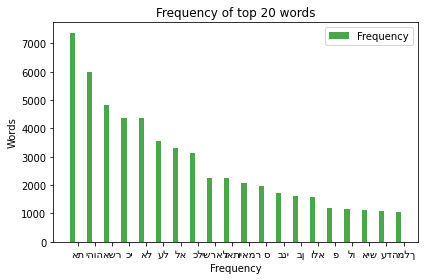

In [ ]:
data = counter.most_common(20)

n_verses = len(data)

vals_words = [x[1] for x in data]
legends_words = [x[0] for x in data]

fig, ax = plt.subplots()

index = np.arange(n_verses)
bar_width = 0.3

rects1 = plt.bar(index, vals_words, bar_width,
                 alpha=0.7,
                 color='g',
                 label='Frequency')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency of top 20 words')
plt.xticks(index + bar_width, legends_words)
plt.legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

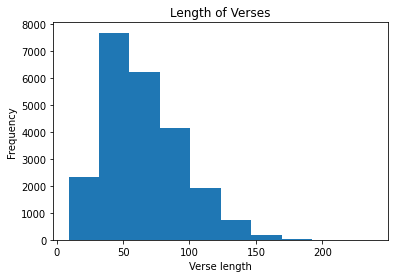

In [ ]:
# Plot the frequency of verse lengths. This is useful to understand whether there is a large discrepancy in verse lengths within books.
# This is another lens into style because a book with long verses may be stylistically different to a verse with shorter verses.
str_lengths = [len(string) for string in hebrew_script_data.text]
plt.hist(str_lengths)
plt.title('Length of Verses')
plt.xlabel('Verse length')
plt.ylabel('Frequency')

## Section 3: Exploring and Encoding Elements of Authorship Style

We attempt to dig deeper into the types of features that may distinguish style between authors (rather than semantics or random variation). We encode several elements:
- Verse length
- Average word length (per verse)
- Standard deviation of word length (per verse)
- Number of conjunctions (per verse)
- Name of God used in verse (yhwh, el, hashem, adonai, elohim)
- Indicator of presence of 50 most common words

Some of these features are manually analysed through literary analysis by Biblical scholars. The distinguishing features that scholars have used to theorise that the Hebrew Bible is written by a number of different authors are, firstly, differences in terminology. For example, ‘Havilah is descendant of Shem’, contrasted with ‘Havilah is descendent of Ham’. Secondly, there are distinctive, and recurring, metaphors used by particular authors (for example, the sky as a dome). This is also true of different words for "God," which is why we explicilty encode those here.

One problem with many word embedding models (such as TF-IDF) is that we'd pick up more differences in semantics rather than in style. One way we can try to detect differences in style is to see what types of common words - such as conjunctions and prepositions - are present in each verse. This way, the semantics may be the same, but we'll pick up authors' differences in proclivity to use different common words to connect ideas. We encode both common words and conjunctions here.

**Note:** We also attempted to use a TF-IDF model (topic modeling approach), which calculated the dominant topic and keywords as well as the percentage contribution from each verse. However, when inspecting the output, we recognized that smaller and more common words were ignored. The model was, instead, picking up semantically meaningful words (nouns, proper nouns, etc.) rather than common words (conjunctions, prepositions, etc.) that are more indiciative of style. So, we decided to use the following alternative approach,which explicitly uses common words and conjunctions as model features.

In [ ]:
# process most common words
num_most_common_words = 50

tokenizer = RegexpTokenizer(r'\w+')
hebrew_words = hebrew_script_data.text.values
hebrew_words = '-'.join(hebrew_words)
hebrew_words = tokenizer.tokenize(hebrew_words)
c = Counter(hebrew_words)
common_word_vec = np.array(list(map(lambda x : x[0].strip(), c.most_common(num_most_common_words))))

In [ ]:
# different specific features
conjunctions = ['אבל', 'אגב', 'או', 'אולם', 'אי', 'אילו', 'אך', 'אלא', 'אלו', 'אלמלא', 'אם', 'אםם', 'אע״פ', 'אשר', 'בעוד', 'ברם', 'היינו', 'ו/או', 'ו־', 'יען', 'כאילו', 'כאשר', 'כי', 'כש־', 'לו', 'לולא', 'מכיוון', 'משמע', 'פן', 'ש־']
names_of_god = ['יהוה', 'אל', 'השם', 'אדני', 'אלהים']
english_names_of_god = ['yhwh', 'el', 'hashem', 'adonai', 'elohim']

def vec_to_int(v): #used to identify which name of god was used in a verse, returns -1 if none are used
    if max(v) == 0:
        return -1
    return np.argmax(np.array(v))

In [ ]:
# functions to calculate extra features for dataframe

verse_len = lambda row : len(row['text'].split(' '))
avg_word_len = lambda row : np.mean(np.array(list(map(lambda x : len(x), row['text'].split(' ')))))
std_word_len = lambda row : np.std(np.array(list(map(lambda x : len(x), row['text'].split(' ')))))
num_occurences = lambda word, list_of_words : sum([word == w for w in list_of_words])
common_word_presence = lambda row : [ num_occurences(c, row['text'].split(' ')) for c in common_word_vec]
num_conjunctions = lambda row : sum([num_occurences(c, row['text'].split(' ')) for c in conjunctions])
name_of_god = lambda row : vec_to_int([num_occurences(g, row['text'].split(' ')) for g in names_of_god])

#apply above functions to create new dataframe columns
hebrew_script_data['verse_len'] = hebrew_script_data.apply(verse_len, axis = 1)
hebrew_script_data['avg_word_len'] = hebrew_script_data.apply(avg_word_len, axis = 1)
hebrew_script_data['std_word_len'] = hebrew_script_data.apply(std_word_len, axis = 1)
hebrew_script_data['common_word_vec'] = hebrew_script_data.apply(common_word_presence, axis = 1)
hebrew_script_data['num_conjunctions'] = hebrew_script_data.apply(num_conjunctions, axis = 1)
hebrew_script_data['name_of_god'] = hebrew_script_data.apply(name_of_god, axis = 1)

In [ ]:
hebrew_script_data.head()

,all_text,label,book,text,Bert_probs_1,Bert_probs_2,verse_len,avg_word_len,std_word_len,common_word_vec,num_conjunctions,name_of_god
0,Gen 1:1 בראשית ברא אלהים את השמים ואת הארץ,Gen 1:1,Gen,בראשית ברא אלהים את השמים ואת הארץ,0.480990,0.537603,7,4.000000,1.309307,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,4
1,Gen 1:2 והארץ היתה תהו ובהו וחשך על־פני תהום ו...,Gen 1:2,Gen,והארץ היתה תהו ובהו וחשך על־פני תהום ורוח אלהי...,0.863738,0.172903,12,4.500000,0.866025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4
2,Gen 1:3 ויאמר אלהים יהי אור ויהי־אור,Gen 1:3,Gen,ויאמר אלהים יהי אור ויהי־אור,0.715377,0.304718,5,4.800000,1.833030,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,4
3,Gen 1:4 וירא אלהים את־האור כי־טוב ויבדל אלהים ...,Gen 1:4,Gen,וירא אלהים את־האור כי־טוב ויבדל אלהים בין האור...,0.830044,0.201569,10,4.700000,1.100000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4
4,Gen 1:5 ויקרא אלהים לאור יום ולחשך קרא לילה וי...,Gen 1:5,Gen,ויקרא אלהים לאור יום ולחשך קרא לילה ויהי־ערב ו...,0.918735,0.121493,12,4.333333,1.972027,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4


**Visualizing Differences in Name for God**

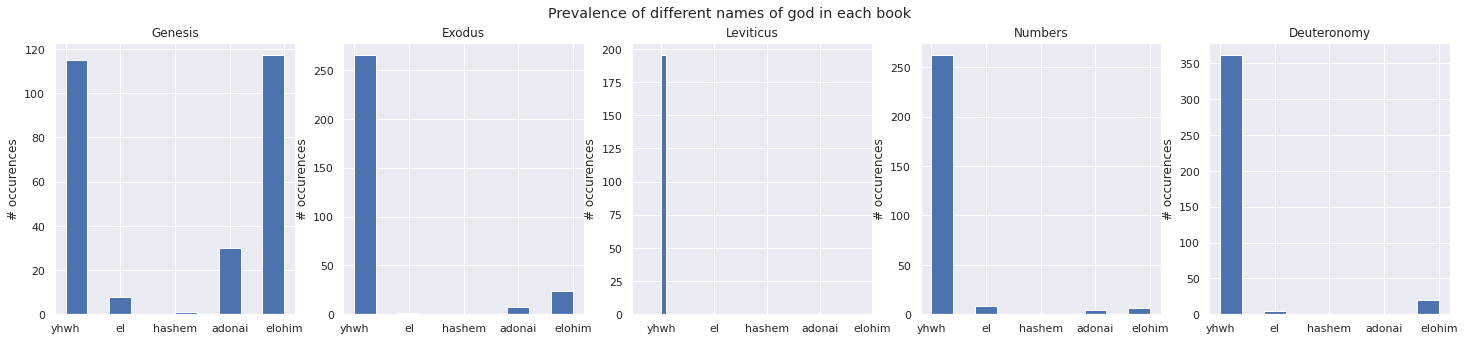

In [ ]:
# separate dataframes by book

gen_df = hebrew_script_data[hebrew_script_data['book'] == 'Gen']
exo_df = hebrew_script_data[hebrew_script_data['book'] == 'Exo']
lev_df = hebrew_script_data[hebrew_script_data['book'] == 'Lev']
num_df = hebrew_script_data[hebrew_script_data['book'] == 'Num']
deu_df = hebrew_script_data[hebrew_script_data['book'] == 'Deu']
book_dfs = [gen_df, exo_df, lev_df, num_df, deu_df]
book_titles = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy']

fig, ax = plt.subplots(1, 5, figsize = (25, 5))
fig.suptitle('Prevalence of different names of god in each book')
for i in range(5):
    book_df = book_dfs[i]
    title = book_titles[i]
    ax[i].hist(list(filter(lambda x : x != -1, book_df.name_of_god)))
    ax[i].set_title(title)
    ax[i].set_xticks(np.arange(0, 5))
    ax[i].set_xticklabels(english_names_of_god)
    ax[i].set_ylabel('# occurences')
plt.show()

**Visualizing Differences in Verse Length**

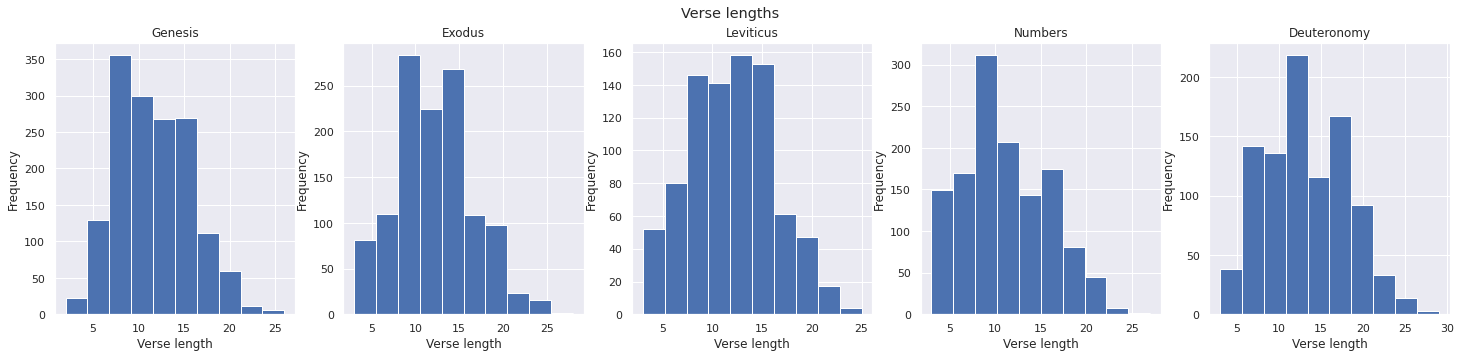

In [ ]:
## Variation in verse length at the book level
fig, ax = plt.subplots(1, 5, figsize = (25, 5))
fig.suptitle('Verse lengths')
for i in range(5):
    book_df = book_dfs[i]
    title = book_titles[i]
    ax[i].hist(book_df.verse_len)
    ax[i].set_title(title)
    ax[i].set_xlabel('Verse length')
    ax[i].set_ylabel('Frequency')
plt.show()

Looks like a similar distribution for each verse. Leviticus and Numbers are more left skewed with a higher mode in the center, and Genesis and Exodus are more centrally distributed. But the differences are not easily visible across the books at a macro level.

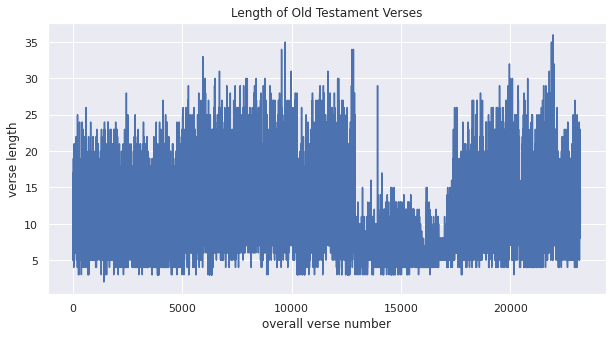

In [ ]:
## Individual variation in verse length
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(hebrew_script_data.verse_len)
ax.set_xlabel('overall verse number')
ax.set_ylabel('verse length')
ax.set_title('Length of Old Testament Verses')
plt.show()

**Visualizing Differences in Number of Conjunctions Used**

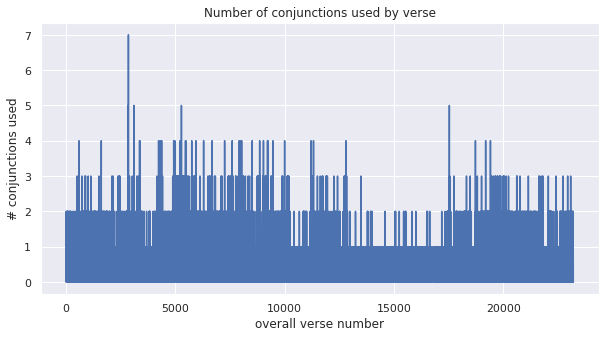

In [ ]:
## Number of conjunctions by verse
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(hebrew_script_data.num_conjunctions)
ax.set_xlabel('overall verse number')
ax.set_ylabel('# conjunctions used')
ax.set_title('Number of conjunctions used by verse')
plt.show()

**Visualizing the Most Common Words, and Their Use by Verse**

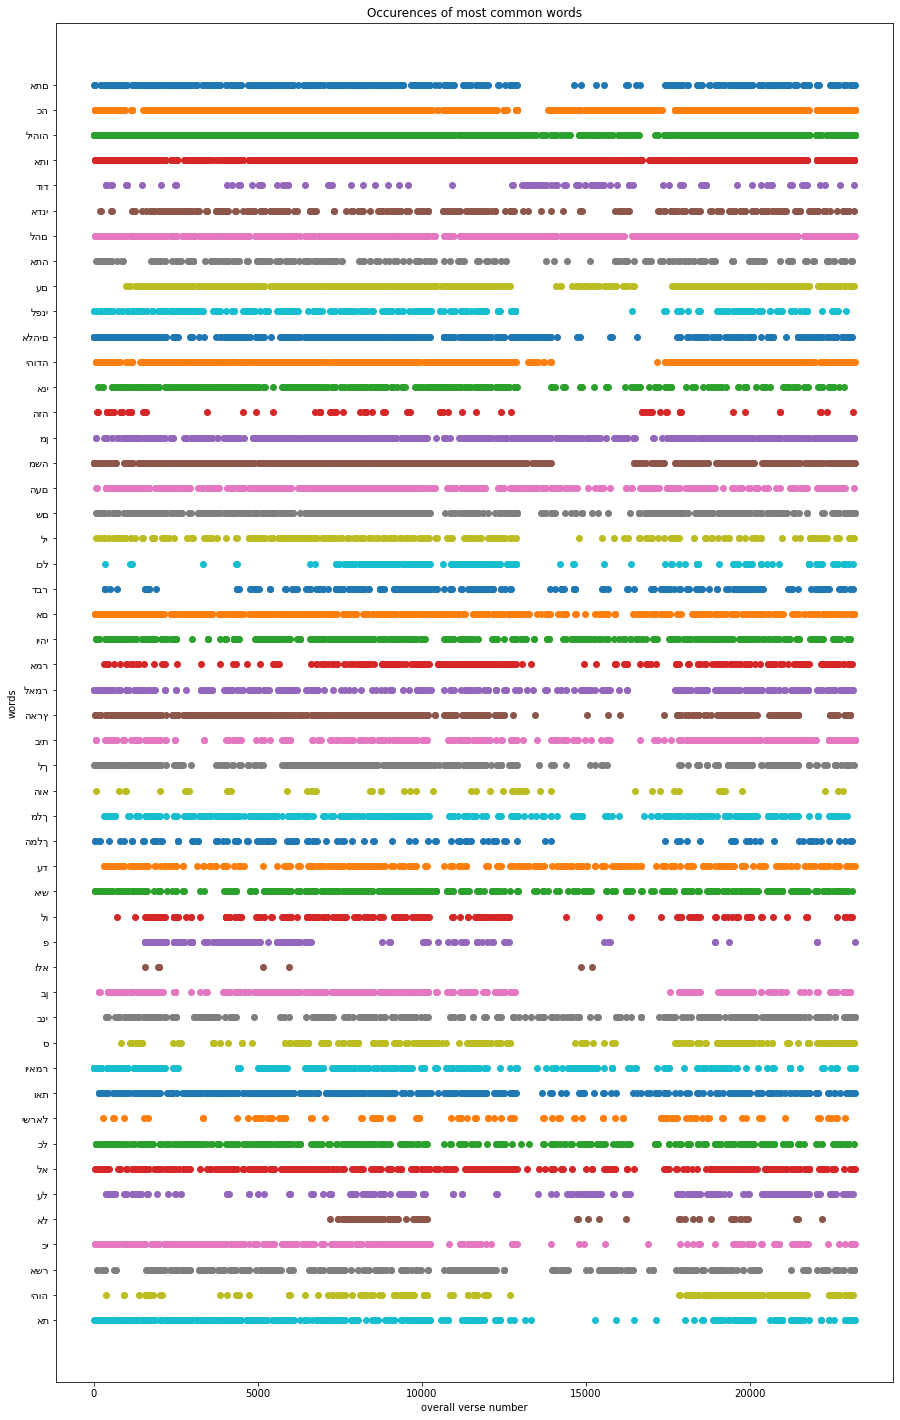

In [ ]:
##Use of most common words, by verse
common_word_data = {i : [] for i in range(len(common_word_vec))}
for n in range(len(hebrew_script_data)):
    row = hebrew_script_data.loc[n]
    l = row['common_word_vec']
    for i in range(len(common_word_vec)):
        if l[i] != 0:
            common_word_data[i].append(n)

fig, ax = plt.subplots(figsize = (15, int(0.5*len(common_word_vec))))
for i in range(len(common_word_vec)):
    total_verse_nums = common_word_data[i]
    plt.scatter(total_verse_nums, (len(common_word_vec) - i)*np.ones(len(total_verse_nums)), label = common_word_vec[i])

ax.set_title('Occurences of most common words')
ax.set_xlabel('overall verse number')
ax.set_ylabel('words')
ax.set_yticks(np.arange(1, len(common_word_vec) + 1))
ax.set_yticklabels(common_word_vec)
plt.show()

For each verse in the old testament progressing on the x-axis, we add a point to the graph indicating the presence of each of the $k$ most common words (for now we choose $k$ = 50).

Notably, we observe that regions on the x-axis are distinctly marked by the presence or absence of some of these words. Even though we do not know what all these words mean, we can see that certain words are highly representative of certain portions of the text rather than others.

This is a strong indication that distinctly paying attention to the combination of common words present in a verse will be a useful additional feature for clustering.


## Section 4: Baseline Model and Performance on Composite Set (test set)

In order to build a baseline model we simply use average word length within verses to perform clustering. We will also default to K = 2 clusters. This baseline will allow us to see improvements from potentially:
- Changing the number of authors (nubmer of clusters)
- Adding more stylistic features to our clustering vector
- Using BERT sentence embedder to also aid our cluster

We will follow precedents from Biblical Scholarship literature to verify our model. The reason for this is that we want to compare our model to existing work, and therefore utilising a similar test set to that of Biblical scholars will provide a more replicable benchmark. Thus we follow the Koppel et. al. (2011) approach of building composite books sliced from seperate Hebrew Bible books. We use Ezekiel and Job because these are the books which have most distinctive styles and which many Biblical believe to be most likely to be derived from different sources. Specifically, we generate two composite test texts. The first is a composite of Ezekiel and Job. Ezekiel falls under the genre of 'Prophets' books while Job falls under the genre of 'Writings' books. Therefore we would expect that if we have been able to create a representation of the Hebrew Bible that accurately captures style then our clustering should be able to decipher between these genres. Similarly, we create a composite of Proverbs (Writings) and Isaiah (Prophets). 


In [ ]:
# Packages for Clustering
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

**Generating Composite Texts (described above)**

In [ ]:
# Ezekiel-Job Composite Text
ezekiel_job = hebrew_script_data.loc[(hebrew_script_data.book == 'Eze') | (hebrew_script_data.book == 'Job')]
ezekiel_job = ezekiel_job.sample(frac = 1)

# Isaiah-Proverbs Composite Text
isaiah_proverbs = hebrew_script_data.loc[(hebrew_script_data.book == 'Isa') | (hebrew_script_data.book == 'Pro')]
isaiah_proverbs = isaiah_proverbs.sample(frac = 1)

**Measuring Performance**

One way to quantitatively measure the quality of our clusters is to measure how "pure" our lusters are. For example, on our first composite text, the ideal clusters would have two clusters: one that is purely Job and one that is purely Ezekiel (order doesn't matter - as long as they are in two separate clusters, it doesn't matter which is "Cluster 1" and which is "Cluster 2"). We can directly measure the purity of our clusters using the purity score, which can be defined by ([see source](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)): 

$$
Purity = \frac{1}{N}\Sigma_{k} max_{j}| w_{k} \cap c_{j} |
$$

Where $w_{k}$ is cluster k and $c_{j}$ is class j.

The purity score can be roughly interpreted as the percent of data points classified correctly. Perfect purity would have a score of 1. The lowest purity score is 0. 

In [ ]:
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
## Function for purity score, adapted from implementation here: https://stackoverflow.com/questions/34047540/python-clustering-purity-metric
def purity_score(y_true, y_pred):
    conf_matrix = contingency_matrix(y_true, y_pred) # confusion matrix
    return np.sum(np.amax(conf_matrix, axis=0)) / np.sum(conf_matrix) # purity score

Purity score for Ezekiel and Job Clustering (Basline Model):  0.543




[Text(0, 0.5, 'Verse Count'),
 Text(0.5, 0, 'Clusters'),
 Text(0.5, 1.0, 'Clusters when k=2, Ezekiel and Job, Baseline Model')]

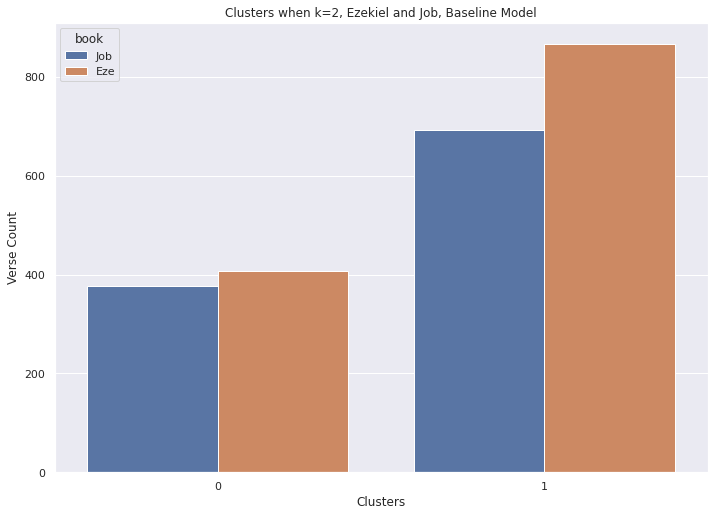

In [ ]:
## Clustering results for Ezekial Job

## Cluster by book
e_j_features = np.array(ezekiel_job.avg_word_len.values).reshape(-1,1)
fitted_e_j = KMeans(n_clusters=2,n_init=46,random_state=109).fit(e_j_features)
ezekiel_job['final_clusters'] = fitted_e_j.labels_

#Print purity score
print('Purity score for Ezekiel and Job Clustering (Basline Model): ', round(purity_score(ezekiel_job['book'].values,ezekiel_job['final_clusters'].values), 3))
print('\n')
## Plot clustering by book
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=ezekiel_job, x="final_clusters", hue="book").set(title='Clusters when k=2, Ezekiel and Job, Baseline Model', xlabel='Clusters', ylabel='Verse Count')

Our baseline model had a purity of 0.543, which is just above random guessing. It also, visually, did not distinguish Job and Ezekiel very well, as each cluster has a good mix of both books. Our full model will aim to improve on this purity.

Purity score for Isaiah and Proverbs:  0.585




[Text(0, 0.5, 'Verse Count'),
 Text(0.5, 0, 'Clusters'),
 Text(0.5, 1.0, 'Clusters when k=2')]

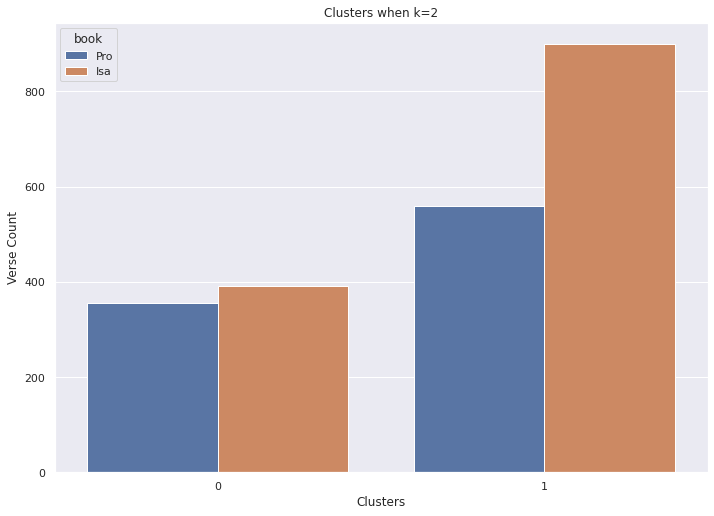

In [ ]:
## Clustering results for Isaiah and Proverbs

## Cluster by book
i_p_features = np.array(isaiah_proverbs.avg_word_len.values).reshape(-1,1)
fitted_i_p = KMeans(n_clusters=2,n_init=46,random_state=109).fit(i_p_features)
isaiah_proverbs['final_clusters'] = fitted_i_p.labels_

#Print purity score
print('Purity score for Isaiah and Proverbs: ', round(purity_score(isaiah_proverbs['book'].values,isaiah_proverbs['final_clusters'].values), 3))
print('\n')
## Plot clustering by book
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=isaiah_proverbs, x="final_clusters", hue="book").set(title='Clusters when k=2', xlabel='Clusters', ylabel='Verse Count')

Similarly with Isiah and Proverbs, our baseline model has a low purity score and clusters that are pretty well mixed between both books. This shows that semantically and stylistically, our baseline model is not learning the differences between texts. So, we'd predict that this model would do a horrendous job and distinguishing between authors in the full Hebrew Bible.

## Section 5: Fine-Tuning BERT

The major aim of our approach is to isolate stylistic features in order to decompose authorial contributions. In order to do this we will fine-tune a BERT model on two similarly styled books (two seperate translations of the Bible). We hypothesise that these are substantively very similar, but stylistically slightly different. Therefore, we aim to train the model to learn only the *stylistic* differences, and thus classify based on style (including syntax and word choice), and less on semantics or substance.  

The two versions of the Bible we used were the King James Version and the Berean Bible. While the King James version was commissioned by the English King James in 1611, the Berean Bible is a modern translation. Therefore, we expected both Bibles to have stylistic differences. Both Bibles were translated from English to Hebrew using Google translate before being using to train the model.

In order to train the model we used pre-trained BERT word-embeddings fine-tuned on the corpus outlined above. Research suggests that BERT word-embeddings primarily extract a representation of the text that concentrates on semantics, but that they also encode some syntactic information. Therefore, in training our model to distringuish between two styles we are aiming to extract specifically the stylistic and syntactic information encoded in the BERT fine-tuned embeddings. Using this model we can predict a class (0 or 1) for each verse in the test corpus. This will give a measure of the model's confidence that a verse is stylistically different from other verses. Then, we'll use those class predictions in our final vector for clustering in the full model.

**Process source texts**

In [ ]:
# Upload file, bsb bible
from google.colab import files
uploaded = files.upload()

Saving bsb.txt to bsb.txt


In [ ]:
bsb_text = "bsb.txt"

In [ ]:
bsb_data = pd.read_csv(bsb_text ,delimiter='\r\n', header=None, names=["all_text"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
bsb_data.head()

,all_text
0,Genesis 1:1\tIn the beginning God created the ...
1,Genesis 1:2\tNow the earth was formless and vo...
2,"Genesis 1:3\tAnd God said, “Let there be light..."
3,Genesis 1:4\tAnd God saw that the light was go...
4,"Genesis 1:5\tGod called the light “day,” and t..."


In [ ]:
#translate_text = translator.translate('God created these heaven and earth',lang_tgt='he') 

In [ ]:
list_3 = []
list_4 = []
for sentence in bsb_data.all_text.values:
  try:
    sent_1 = sentence[:sentence.index('\t')]
    sent_2 = sentence[sentence.index('\t') + 1:]
    list_3.append(sent_1)
    list_4.append(sent_2)
  except:
    list_3.append(sentence)
    list_4.append(sentence)

In [ ]:
bsb_data['label'] = list_3
bsb_data['text'] = list_4

In [ ]:
bsb_data['text'] = bsb_data['text'].str.replace('[^\w\s]','')

In [ ]:
bsb_data.head()

,all_text,label,text
0,Genesis 1:1\tIn the beginning God created the ...,Genesis 1:1,In the beginning God created the heavens and t...
1,Genesis 1:2\tNow the earth was formless and vo...,Genesis 1:2,Now the earth was formless and void and darkne...
2,"Genesis 1:3\tAnd God said, “Let there be light...",Genesis 1:3,And God said Let there be light and there was ...
3,Genesis 1:4\tAnd God saw that the light was go...,Genesis 1:4,And God saw that the light was good and He sep...
4,"Genesis 1:5\tGod called the light “day,” and t...",Genesis 1:5,God called the light day and the darkness He c...


In [ ]:
# # Upload file, king james bible
# from google.colab import files
# uploaded = files.upload()

Saving kjv.txt to kjv (1).txt


In [ ]:
kjv_text = "kjv.txt"

In [ ]:
kjv_data = pd.read_csv(kjv_text ,delimiter='\r\n', header=None, names=["all_text"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
kjv_data.tail()

,all_text
23140,Mal 4:2 But unto you that fear my name shall t...
23141,Mal 4:3 And ye shall tread down the wicked; fo...
23142,Mal 4:4 Remember ye the law of Moses my servan...
23143,"Mal 4:5 Behold, I will send you Elijah the pro..."
23144,Mal 4:6 And he shall turn the heart of the fat...


In [ ]:
# # Reset BSB to be same number of verses as King James (for Philip's file version)
# bsb_data = bsb_data[0:len(kjv_data)]

In [ ]:
print('Number of verses in BSB version: ', len(bsb_data))
print('Number of verses in King James version: ', len(bsb_data))

Number of verses in BSB version:  23145
Number of verses in King James version:  23145


In [ ]:
kjv_data['label'] = kjv_data['all_text'].str[:8]
kjv_data['book'] = kjv_data['all_text'].str[:3]
kjv_data['text'] = kjv_data['all_text'].apply(splitlabels)

In [ ]:
kjv_data['text'] = kjv_data['text'].str.replace('[^\w\s]','')

In [ ]:
kjv_data.head()

,all_text,label,book,text
0,Gen 1:1 In the beginning God created the heave...,Gen 1:1,Gen,In the beginning God created the heaven and th...
1,"Gen 1:2 And the earth was without form, and vo...",Gen 1:2,Gen,And the earth was without form and void and da...
2,"Gen 1:3 And God said, Let there be light: and ...",Gen 1:3,Gen,And God said Let there be light and there was ...
3,"Gen 1:4 And God saw the light, that [it was] g...",Gen 1:4,Gen,And God saw the light that it was good and God...
4,"Gen 1:5 And God called the light Day, and the ...",Gen 1:5,Gen,And God called the light Day and the darkness ...


**Translated Versions**

After running both English versions (King James and BSB) through Google Translate into Hebrew, we download the Hebrew versions and then fine-tune the BERT model on distinguishing between the two (a stylistic difference).

In [ ]:
# Upload file, translated king james (to hebrew)
from google.colab import files
uploaded = files.upload()

Saving king_james_to_hebrew.txt to king_james_to_hebrew.txt


In [ ]:
# Upload file, translated bsb (to hebrew)
from google.colab import files
uploaded = files.upload()

Saving bsb_to_hebrew.txt to bsb_to_hebrew.txt


In [ ]:
kjv_to_hebrew = pd.read_csv('king_james_to_hebrew.txt',delimiter='\r\n', header=None, names=["all_text"])
bsb_to_hebrew = pd.read_csv('bsb_to_hebrew.txt',delimiter='\r\n', header=None, names=["all_text"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
# add Hebrew versions to our dataframes
kjv_data['hebrew_text'] = kjv_to_hebrew['all_text'].values
bsb_data['hebrew_text'] = bsb_to_hebrew['all_text'].values

In [ ]:
kjv_data.head()

,all_text,label,book,text,hebrew_text
0,Gen 1:1 In the beginning God created the heave...,Gen 1:1,Gen,In the beginning God created the heaven and th...,בהתחלה ברא אלוהים את השמים ואת הארץ
1,"Gen 1:2 And the earth was without form, and vo...",Gen 1:2,Gen,And the earth was without form and void and da...,והאדמה הייתה ללא צורה וחלילה וחושך היה על פני ...
2,"Gen 1:3 And God said, Let there be light: and ...",Gen 1:3,Gen,And God said Let there be light and there was ...,ויאמר אלוהים שיהיה אור והיה אור
3,"Gen 1:4 And God saw the light, that [it was] g...",Gen 1:4,Gen,And God saw the light that it was good and God...,ואלוהים ראה את האור שהוא טוב ואלוהים חילק את ה...
4,"Gen 1:5 And God called the light Day, and the ...",Gen 1:5,Gen,And God called the light Day and the darkness ...,ואלוהים קרא לאור האור לחושך שהוא קרא לילה והער...


In [ ]:
bsb_data.head()

,all_text,label,text,hebrew_text
0,Genesis 1:1\tIn the beginning God created the ...,Genesis 1:1,In the beginning God created the heavens and t...,בראשית ברא אלוהים את השמים ואת הארץ
1,Genesis 1:2\tNow the earth was formless and vo...,Genesis 1:2,Now the earth was formless and void and darkne...,עתה האדמה הייתה חסרת צורה וחללה וחושך היה מעל ...
2,"Genesis 1:3\tAnd God said, “Let there be light...",Genesis 1:3,And God said Let there be light and there was ...,ויאמר אלוהים שיהיה אור והיה אור
3,Genesis 1:4\tAnd God saw that the light was go...,Genesis 1:4,And God saw that the light was good and He sep...,ואלוהים ראה שהאור טוב והוא הפריד בין האור לחושך
4,"Genesis 1:5\tGod called the light “day,” and t...",Genesis 1:5,God called the light day and the darkness He c...,אלוהים קרא לאור היום והחושך הוא קרא לילה והיה ...


We see targest for reach source, to train BERT in a supervised fashion. Then, we pipeline the data.

In [ ]:
kjv_data['target'] = 0

In [ ]:
bsb_data['target'] = 1

In [ ]:
combined = pd.concat([kjv_data, bsb_data], ignore_index=True, sort=False)

In [ ]:
from transformers import pipeline

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

In [ ]:
data_x = combined.hebrew_text.values
data_y = combined.target.values

In [ ]:
from sklearn.model_selection import train_test_split
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 37032
validate_x count: 9258


In [ ]:
# Feature constraints
sequence_length = 256

# Train
train_x_processed = tokenizer.batch_encode_plus(
        train_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

# Validation
validate_x_processed = tokenizer.batch_encode_plus(
        validate_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

print(train_x_processed.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
print("train_x_processed shape:", train_x_processed["input_ids"].shape)
print("validate_x_processed shape:", validate_x_processed["input_ids"].shape)
# First sample
print("First sample:")
print("input_ids:",train_x_processed["input_ids"][0][:10])
print("token_type_ids:",train_x_processed["token_type_ids"][0][:10])
print("attention_mask:",train_x_processed["attention_mask"][0][:10])
# Second sample
print("Second sample:")
print("input_ids:",train_x_processed["input_ids"][1][:10])
print("token_type_ids:",train_x_processed["token_type_ids"][1][:10])
print("attention_mask:",train_x_processed["attention_mask"][1][:10])

train_x_processed shape: (37032, 256)
validate_x_processed shape: (9258, 256)
First sample:
input_ids: tf.Tensor([  101 19850 58914 58843 24196 10589   435 19688 15779   421], shape=(10,), dtype=int32)
token_type_ids: tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)
attention_mask: tf.Tensor([1 1 1 1 1 1 1 1 1 1], shape=(10,), dtype=int32)
Second sample:
input_ids: tf.Tensor([  101 33641   433 14175 14369 35287 64720 60351 19479 17215], shape=(10,), dtype=int32)
token_type_ids: tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int32)
attention_mask: tf.Tensor([1 1 1 1 1 1 1 1 1 1], shape=(10,), dtype=int32)


In [ ]:
batch_size = 16
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

# Converts to y to binary class matrix (One-hot-encoded)
#train_processed_y = to_categorical(train_y, num_classes=num_classes, dtype='int32')
#validate_processed_y = to_categorical(validate_y, num_classes=num_classes, dtype='int32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices(((train_x_processed["input_ids"],
                                                  train_x_processed["token_type_ids"],
                                                  train_x_processed["attention_mask"]), train_y))
validation_data = tf.data.Dataset.from_tensor_slices(((validate_x_processed["input_ids"],
                                                  validate_x_processed["token_type_ids"],
                                                  validate_x_processed["attention_mask"]), validate_y))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
# We don't shuffle the validation data here.
#validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None,)), types: ((tf.int32, tf.int32, tf.int32), tf.int64)>
validation_data <PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None,)), types: ((tf.int32, tf.int32, tf.int32), tf.int64)>


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
def build_pretrained_bert(num_classes):
  # Set the model name as
  model_name = 'bert_pretrained_'+str(int(time.time()))
  model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',name=model_name, num_labels=2)
  return model

In [ ]:
# From Tensorflow Documentation
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs) # Extract this layer.
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Now that we have formatted our data, we will fine-tune BERT through training. We use just a single epoch due to the massive size of the BERT model.

In [ ]:
############################
# Training Params
############################
learning_rate = 2e-5
epochs = 1

# Free up memory
K.clear_session()

num_classes = 2

# Build the model
model = build_pretrained_bert(num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.Adam(lr=learning_rate, epsilon=1e-08)
# Loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[metric])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "bert_pretrained_1620656783"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________
None
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experime

In [ ]:
## Different ways to load model

# # load model
# # # Create a new model instance
# model = create_model()

# # Restore the weights
# model.load_weights('drive/MyDrive/fine_tuned_BERT_weights')
# model.load_weights('drive/MyDrive/fine_tuned_BERT_weights.h5')

# # load model (WE USED THIS ONE)
# model = tf.keras.models.load_model('/content/drive/MyDrive/fine_tuned_BERT.pth')

# # # load model
# model = tf.keras.models.load_model('/content/drive/MyDrive/fine_tune_BERT')

**Performance**

We now view the performance of our model in distinguishing between the two bible version, in order to gauge how much we were able to train it to pick up on differences between styles.

In [ ]:
## Get validation results for BERT model
def bert_matrix(model, test_data):
  ytrue = np.concatenate([y for x, y in test_data], axis=0)            
  pred_probs = model.predict(test_data)
  predictions = np.argmax(pred_probs['logits'],axis=1)
  conf_matrix = confusion_matrix(ytrue, predictions)
  return ytrue, pred_probs, predictions, conf_matrix

# test results for BERT
ytrue_BERT, pred_probs_BERT, predictions_BERT, conf_matrix_BERT = bert_matrix(model, validation_data)

In [ ]:
##Overall accuracy and confusion matrix
print('Accuracy: ', np.mean(ytrue_BERT == predictions_BERT))
print(conf_matrix_BERT)

Accuracy:  0.7603154028947937
[[3821  827]
 [1392 3218]]


We obtained about 76% accuracy on predicting between the two sources texts in validation. Satisfied with this accuracy (considering the texts have the same semantic meaning, any accuracy above 50% is impressive), we now move on to getting predictions from this fine-tuned BERT model on the full Hebrew Bible dataset.

**Note:** These predictions are not our final cluster predictions for authorship. These predictions are one of the features we will consider when clustering on the full text to determine authorship. Our hope is that these predictions will add to the stylistic features we have encoded for clustering.

In [ ]:
test_x = hebrew_script_data['text'].values

In [ ]:
## Pipeline to predict on full Hebrew bible
# Feature constraints
sequence_length = 256

# Test
test_x_processed = tokenizer.batch_encode_plus(
        test_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

print(test_x_processed.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [ ]:
batch_size = 16

test_data = tf.data.Dataset.from_tensor_slices(((test_x_processed["input_ids"],
                                                  test_x_processed["token_type_ids"],
                                                  test_x_processed["attention_mask"])))

test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

print("test_data", test_data)

test_data <PrefetchDataset shapes: ((None, 256), (None, 256), (None, 256)), types: (tf.int32, tf.int32, tf.int32)>


In [ ]:
## Get final predictions
pred_probs = model.predict(test_data)
predictions = np.argmax(pred_probs['logits'],axis=1)

In [ ]:
# save predictions and prediction probabilities
%store pred_probs
%store predictions

# load predictions and prediction probabilities
# %store -r pred_probs
# %store -r predictions

Stored 'pred_probs' (TFSequenceClassifierOutput)
Stored 'predictions' (ndarray)


We visualize our predictions by book (the first five books of the Hebrew Bible), to see the proportion predicted between authorship styles.

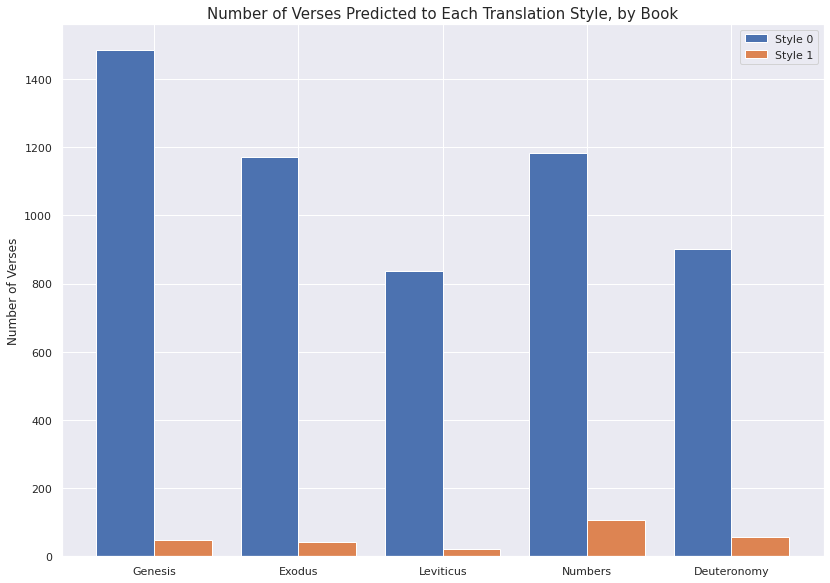

In [ ]:
##Show delineation of styles between books
#based on matplotlib documenation: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
labels = ['Genesis','Exodus','Leviticus','Numbers','Deuteronomy']
author_0 = []
author_1 = []

hebrew_script_data['fine_tune_preds'] = predictions

list_of_books = ['Gen','Exo','Lev','Num','Deu']
for i, book in enumerate(list_of_books):
    book_df = hebrew_script_data[hebrew_script_data['book'] == book]
    author_0.append(pd.value_counts(book_df.fine_tune_preds)[0])
    author_1.append(pd.value_counts(book_df.fine_tune_preds)[1])

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, author_0, width, label='Style 0')
rects2 = ax.bar(x + width/2, author_1, width, label='Style 1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Verses')
ax.set_title('Number of Verses Predicted to Each Translation Style, by Book', size = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

We can see our predictions tend to favor one translations style over the other - in this case, King James over the BSB. This makes some sense, as the King James version is the older source text. 

The Hebrew Bible itself has likely changed over the course of many years, with different copies and translations. Our Hebrew Bible file, while ancient, is still not the "true original" document. The Bible itself was written down after oral traditions and stories; then, the written document likely experienced updates from different sources. We may be able to distinguish sources based on features of their writing that are more indiciative of the times in which they were writing.

Although the King James Bible and BSB are neither as old as the sources of the Hebrew Bible, having our model learn what differences between any temporal periods "looks like" may help it make this distinction for the Hebrew Bible itself. Adding these predictions to our model can help us potentially pick up on older or more modern authorship tones that may be mixed into the text.

## Section 6: Making Our Full Model - Combining Stylistic Features with BERT Embeddings




For our composite clustering method, we will be grouping verses based on manually selected features in addition to the BERT sentence embeddings. 

SBert sentence embeddings are particularly useful for our use case. This is a state-of-the-art method of using embeddings. As opposed to using word embeddings we start with the assumption that sentence embeddings will better represent style because they are more likely to be able to extract syntactic information beyond the word-level, which is often critical for authorial voice. 

As described before, here are the additional stylistic features we've selected to encode:
- Verse length
- Average word length (per verse)
- Standard deviation of word length (per verse)
- Number of conjunctions (per verse)
- Name of God used in verse (yhwh, el, hashem, adonai, elohim)
- Indicator of presence of 50 most common words

We then, for each feature, selected a simple weight for each manually selected feature based on its perceived importance from our EDA. As mentioned before, we also add the fine-tuned BERT predictions to our set of features. These are, again, manually weighted.

In the end, we will cluster based on the full vector of BERT sentence embeddings, manually selected sytlistic features, and the fine-tune BERT style predictions.


**Obtaining the BERT Sentence Embeddings**

In [ ]:
## Add BERT sentence embeddings
# Install the library using pip
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 1.2MB 31.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=0a05a20e572694d0e826d6315ccd63a0b13600282a4fa9cd63c090e07e63f87c
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [ ]:
##Embeddings for Hebrew Bible
embedder = SentenceTransformer('distiluse-base-multilingual-cased-v2')
#embeddings = embedder.encode(['In the beginning', 'בראשית ברא אלהים את השמים ואת הארץ'])
#print(embeddings)

hebrew_bible_embeddings = embedder.encode(hebrew_script_data.text.values)

In [ ]:
# view embeddings
print('Shape: ', hebrew_bible_embeddings.shape)

print('\nExample embedding: ')
print(hebrew_bible_embeddings[0][0:25])

Shape:  (23213, 512)

Example embedding: 
[ 0.00505083 -0.01729345 -0.00861085  0.00378045  0.05114419 -0.04540303
 -0.04915371  0.07074826  0.01200883 -0.01680007 -0.00564281 -0.05225421
 -0.05353218  0.00795087 -0.00078376  0.02760486  0.0171278   0.03473846
  0.00575915 -0.02382916 -0.05810509 -0.00595578 -0.00315153  0.00098013
 -0.00708184]


**Adding predictions from fine-tuned BERT**

In [ ]:
## Add label from BERT into dataframe

#class probabilities
def sigmoid(x):
  return 1/(1 + np.exp(-x))

# convert to probabilities, add to dataframe
hebrew_script_data['Bert_probs_1'] = sigmoid(pred_probs['logits'])[:,0]
hebrew_script_data['Bert_probs_2'] = sigmoid(pred_probs['logits'])[:,1]

In [ ]:
## Get mean (absolute value) of BERT Encoding values
embed_mean = np.mean([np.mean(np.absolute(x)) for x in hebrew_bible_embeddings])
embed_mean

0.022183675

In [ ]:
hebrew_script_data.tail()

,all_text,label,book,text,Bert_probs_1,Bert_probs_2,verse_len,avg_word_len,std_word_len,common_word_vec,num_conjunctions,name_of_god
23208,Mal 3:20 וזרחה לכם יראי שמי שמש צדקה ומרפא בכנ...,Mal 3:20,Mal,וזרחה לכם יראי שמי שמש צדקה ומרפא בכנפיה ויצאת...,0.898727,0.146732,12,4.416667,1.037492,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,-1
23209,Mal 3:21 ועסותם רשעים כי־יהיו אפר תחת כפות רגל...,Mal 3:21,Mal,ועסותם רשעים כי־יהיו אפר תחת כפות רגליכם ביום ...,0.871496,0.161544,15,4.000000,1.505545,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
23210,Mal 3:22 זכרו תורת משה עבדי אשר צויתי אותו בחר...,Mal 3:22,Mal,זכרו תורת משה עבדי אשר צויתי אותו בחרב על־כל־י...,0.612077,0.412058,11,4.818182,2.208174,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,-1
23211,Mal 3:23 הנה אנכי שלח לכם את אליה הנביא לפני ב...,Mal 3:23,Mal,הנה אנכי שלח לכם את אליה הנביא לפני בוא יום יה...,0.581781,0.418526,13,3.769231,1.049091,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
23212,Mal 3:24 והשיב לב־אבות על־בנים ולב בנים על־אבו...,Mal 3:24,Mal,והשיב לב־אבות על־בנים ולב בנים על־אבותם פן־אבו...,0.541335,0.448305,10,5.700000,1.734935,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,-1


**Creating vector of stylistic features**

For our composite clustering method, we will be grouping verses based on manually selected features in addition to the BERT sentence embeddings. We then, for each feature, selected a simple weight for each manually selected feature based on its perceived importance from our EDA.

The default weight for a feature is 1. We gave a lower weight of 0.8 to std_word_len, the standard deviation of word lengths in a verse which we hypothesized may show some style information, though it seemed to show a similar distribution among every chapter in Genesis. We gave a higher weight of 1.5 to the indicator for each of the 50 words in common_word_vec, since our plot above demonstrated it to be a possible carrier of information on distinct regions of the text. We gave a higher weight of 1.2 for the number of conjunctions used, because it showed a slight variance in the text that we thought may carry more information than the length of a verse directly. We gave the highest weight of 2 to the choice of the name of god used.

An improved method would be for these weights to be learnable by the model itself instead of semi-arbitrarily chosen from subjective analysis of the text.

In [ ]:
## Make vector of features, normalize all and add manual weights

features = []

for i in range(len(hebrew_script_data)):

  row_features = []
  row = hebrew_script_data.loc[i]
  row_features.append((row['verse_len'] / np.max(hebrew_script_data['verse_len']) - 0.5)*embed_mean)
  row_features.append((row['avg_word_len'] / np.max(hebrew_script_data['avg_word_len']) - 0.5)*embed_mean)
  row_features.append((row['std_word_len'] / np.max(hebrew_script_data['std_word_len']) - 0.5)*embed_mean)
  row_features += list(np.subtract(row['common_word_vec'], 0.5) * embed_mean)
  row_features.append((row['num_conjunctions'] / np.max(hebrew_script_data['num_conjunctions']) - 0.5)*embed_mean)

  #name of god, one-hot encode
  name = row['name_of_god']
  if name == 0:
    row_features += list(np.subtract([1, 0, 0, 0, 0, 0], 0.5) * embed_mean) 
  elif name == 1:
    row_features += list(np.subtract([0, 1, 0, 0, 0, 0], 0.5) * embed_mean) 
  elif name == 2:
    row_features += list(np.subtract([0, 0, 1, 0, 0, 0], 0.5) * embed_mean) 
  elif name == 3:
    row_features += list(np.subtract([0, 0, 0, 1, 0, 0], 0.5) * embed_mean) 
  elif name == 4:
    row_features += list(np.subtract([0, 0, 0, 0, 1, 0], 0.5) * embed_mean) 
  elif name == -1:
    row_features += list(np.subtract([0, 0, 0, 0, 0, 1], 0.5) * embed_mean) 
  
  row_features.append((row['Bert_probs_1'] - 0.5) * embed_mean)
  row_features.append((row['Bert_probs_2'] - 0.5) * embed_mean)

  #append this row to the greater list
  features.append(row_features)

In [ ]:
## Add manual weights to feature vector

#set weights
weights = [1, 1, 0.80] +  [1.5 for i in range(50)]  + [1.2] + [1.5 for i in range(5)] + [1, 1, 1]
weights = list(np.array(weights) * 1.05)

# functions to apply weights
def weight(w, l):
  return [w[i]*l[i] for i in range(len(l))]

# apply the weights, add to dataframe
features =  [weight(weights, f) for f in features]

# print length
print('Should be 62: ', len(features[0]))
print('\n')
# view features vector
features[0]

Should be 62:  62




[-0.007117262498165171,
 -0.0025565333141968015,
 -0.004973877175605921,
 0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 -0.01746964431367815,
 0.01746964431367815,
 -0.0174696

In [ ]:
full_set = []

## Add embeddings to feature set
for i in range(len(hebrew_script_data)):
  feature_set = features[i]
  full_set.append(feature_set + list(hebrew_bible_embeddings[i]))

#new feature dimensions
print('Should be 574: ', len(full_set[0]))
print('Should be 23213: ', len(full_set))
print('\nExample embedding: ')
print(full_set[0])

Should be 574:  574
Should be 23213:  23213

Example embedding: 
[-0.007117262498165171, -0.0025565333141968015, -0.004973877175605921, 0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, 0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, 0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, -0.01746964431367815, 0.0174696

In [ ]:
## Save just features
hebrew_script_data['just_features'] = features

## Save just embeddings
hebrew_script_data['just_embedding'] = list(hebrew_bible_embeddings)

## Save full features
hebrew_script_data['features'] = full_set

In [ ]:
print(len(hebrew_script_data.features[0]))
hebrew_script_data.features

574


0        [-0.007117262498165171, -0.0025565333141968015...
1        [-0.0038821431808173665, -0.00142029628566489,...
2        [-0.008411310225104293, -0.0007385540685457434...
3        [-0.005176190907756488, -0.0009658014742521246...
4        [-0.0038821431808173665, -0.001799041961842194...
                               ...                        
23208    [-0.0038821431808173665, -0.001609669123753541...
23209    [-0.0019410715904086826, -0.002556533314196801...
23210    [-0.004529167044286926, -0.0006972363584173091...
23211    [-0.003235119317347805, -0.0030809504042884537...
23212    [-0.005176190907756488, 0.0013066725828117, -0...
Name: features, Length: 23213, dtype: object

In [ ]:
hebrew_script_data.head()

,all_text,label,book,text,Bert_probs_1,Bert_probs_2,verse_len,avg_word_len,std_word_len,common_word_vec,num_conjunctions,name_of_god,just_features,just_embedding,features
0,Gen 1:1 בראשית ברא אלהים את השמים ואת הארץ,Gen 1:1,Gen,בראשית ברא אלהים את השמים ואת הארץ,0.480990,0.537603,7,4.000000,1.309307,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,4,"[-0.0067783452363477815, -0.002434793632568382...","[0.005050826, -0.017293453, -0.008610847, 0.00...","[-0.0067783452363477815, -0.002434793632568382..."
1,Gen 1:2 והארץ היתה תהו ובהו וחשך על־פני תהום ו...,Gen 1:2,Gen,והארץ היתה תהו ובהו וחשך על־פני תהום ורוח אלהי...,0.863738,0.172903,12,4.500000,0.866025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4,"[-0.003697279219826063, -0.001352663129204657,...","[-0.055693652, -0.020959653, -0.02980494, 0.01...","[-0.003697279219826063, -0.001352663129204657,..."
2,Gen 1:3 ויאמר אלהים יהי אור ויהי־אור,Gen 1:3,Gen,ויאמר אלהים יהי אור ויהי־אור,0.715377,0.304718,5,4.800000,1.833030,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,4,"[-0.00801077164295647, -0.0007033848271864223,...","[0.015538687, -0.0343122, 0.004734553, 0.01548...","[-0.00801077164295647, -0.0007033848271864223,..."
3,Gen 1:4 וירא אלהים את־האור כי־טוב ויבדל אלהים ...,Gen 1:4,Gen,וירא אלהים את־האור כי־טוב ויבדל אלהים בין האור...,0.830044,0.201569,10,4.700000,1.100000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4,"[-0.00492970562643475, -0.0009198109278591663,...","[-0.03711605, -0.03874699, -0.0045202123, -0.0...","[-0.00492970562643475, -0.0009198109278591663,..."
4,Gen 1:5 ויקרא אלהים לאור יום ולחשך קרא לילה וי...,Gen 1:5,Gen,ויקרא אלהים לאור יום ולחשך קרא לילה ויהי־ערב ו...,0.918735,0.121493,12,4.333333,1.972027,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4,"[-0.003697279219826063, -0.0017133732969925662...","[-0.0597608, -0.014555169, -0.0069541256, 0.00...","[-0.003697279219826063, -0.0017133732969925662..."


## Section 7: Choosing the Number of Clusters

In order to decide the optimatl number of clusters - and with it, the optimal number of sources for the Hebrew Bible - we use a multi-pronged approach. We test out different K-Means cluster fits on our custom vectors (BERT sentence embedding, manual sytlistic features, and fine-tuned BERT predictions) at different values of K. We do this fitting on the first five books of the Hebrew Bible.

We will choose the optimal value of K based on an elbow plot, silhoutte plot, and the Gap* statistic. 

Of these methods, the Gap* statistic is the most principled approach, as it's a statistic that explicitly weights the goals of minimizing distances while also penalizing high cluster amounts. The other methods require more "eyeballing" of plots; hopefully, we find that all methods lead to the same conclusion on number of clusters (and number of authors). 

In [ ]:
## Select just first five books
first_five_data = hebrew_script_data.copy().loc[0:5852] # to get to Deuteronomy 34:12
five_set = full_set[0:5853]
first_five_data.shape

(5853, 15)

In [ ]:
first_five_data.tail()

,all_text,label,book,text,verse_len,avg_word_len,std_word_len,common_word_vec,num_conjunctions,name_of_god,Bert_probs_1,Bert_probs_2,features,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9,K_10
5848,Deu 34:8 ויבכו בני ישראל את־משה בערבת מואב שלש...,Deu 34:8,Deu,ויבכו בני ישראל את־משה בערבת מואב שלשים יום וי...,13,4.076923,1.071414,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",1,-1,0.796136,0.215707,"[0.3611111111111111, 0.39774859287054404, 0.15...",1,0,2,0,1,1,1,1,1
5849,Deu 34:9 ויהושע בן־נון מלא רוח חכמה כי־סמך משה...,Deu 34:9,Deu,ויהושע בן־נון מלא רוח חכמה כי־סמך משה את־ידיו ...,17,4.882353,1.640744,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0.793488,0.208933,"[0.4722222222222222, 0.47632711621233864, 0.23...",0,2,1,2,2,2,2,2,2
5850,Deu 34:10 ולא־קם נביא עוד בישראל כמשה אשר ידעו...,Deu 34:1,Deu,ולא־קם נביא עוד בישראל כמשה אשר ידעו יהוה פנים...,10,4.500000,1.284523,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0.755929,0.220032,"[0.2777777777777778, 0.43902439024390244, 0.18...",0,2,1,2,2,2,2,2,2
5851,Deu 34:11 לכל־האתות והמופתים אשר שלחו יהוה לעש...,Deu 34:1,Deu,לכל־האתות והמופתים אשר שלחו יהוה לעשות בארץ מצ...,11,6.000000,2.374103,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,0.655531,0.287426,"[0.3055555555555556, 0.5853658536585366, 0.338...",0,2,1,2,2,2,2,2,2
5852,Deu 34:12 ולכל היד החזקה ולכל המורא הגדול אשר ...,Deu 34:1,Deu,ולכל היד החזקה ולכל המורא הגדול אשר עשה משה לע...,11,4.363636,1.431638,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,-1,0.723149,0.235798,"[0.3055555555555556, 0.425720620842572, 0.2038...",1,1,0,1,5,5,3,3,3


**Fitting different Cluster numbers**

We fit clusters from K = 2 all the way to K = 10

In [ ]:
## Full feature and embedding vector
vec_to_cluster = np.array(five_set)

## Make clusters on full Hebrew Bible
bible_cluster_2 = KMeans(n_clusters=2,n_init=46,random_state=109).fit(vec_to_cluster)

## Store clusters in dataframe
first_five_data['K_2'] = bible_cluster_2.labels_

In [ ]:
print('Number of verses per author, K = 2: ')
pd.value_counts(first_five_data['K_2'].values)

Number of verses per author, K = 2: 


0    4654
1    1199
dtype: int64

In [ ]:
## Clustering for K = 3, 4, 5, 6, 7, 8, 9, 10
bible_cluster_3 = KMeans(n_clusters=3,n_init=46,random_state=109).fit(vec_to_cluster)
bible_cluster_4 = KMeans(n_clusters=4,n_init=46,random_state=109).fit(vec_to_cluster)
bible_cluster_5 = KMeans(n_clusters=5,n_init=46,random_state=109).fit(vec_to_cluster)
bible_cluster_6 = KMeans(n_clusters=6,n_init=46,random_state=109).fit(vec_to_cluster)
bible_cluster_7 = KMeans(n_clusters=7,n_init=46,random_state=109).fit(vec_to_cluster)
bible_cluster_8 = KMeans(n_clusters=8,n_init=46,random_state=109).fit(vec_to_cluster)
bible_cluster_9 = KMeans(n_clusters=9,n_init=46,random_state=109).fit(vec_to_cluster)
bible_cluster_10 = KMeans(n_clusters=10,n_init=46,random_state=109).fit(vec_to_cluster)

## Store clusters in dataframe
first_five_data['K_3'] = bible_cluster_3.labels_
first_five_data['K_4'] = bible_cluster_4.labels_
first_five_data['K_5'] = bible_cluster_5.labels_
first_five_data['K_6'] = bible_cluster_6.labels_
first_five_data['K_7'] = bible_cluster_7.labels_
first_five_data['K_8'] = bible_cluster_8.labels_
first_five_data['K_9'] = bible_cluster_9.labels_
first_five_data['K_10'] = bible_cluster_10.labels_

In [ ]:
print('Number of verses per author, K = 3: ')
print(pd.value_counts(first_five_data['K_3'].values))
print('\n')
print('Number of verses per author, K = 4: ')
print(pd.value_counts(first_five_data['K_4'].values))
print('\n')
print('Number of verses per author, K = 5: ')
print(pd.value_counts(first_five_data['K_5'].values))
print('\n')
print('Number of verses per author, K = 6: ')
print(pd.value_counts(first_five_data['K_6'].values))
print('\n')
print('Number of verses per author, K = 7: ')
print(pd.value_counts(first_five_data['K_7'].values))
print('\n')
print('Number of verses per author, K = 8: ')
print(pd.value_counts(first_five_data['K_8'].values))
print('\n')
print('Number of verses per author, K = 9: ')
print(pd.value_counts(first_five_data['K_9'].values))
print('\n')
print('Number of verses per author, K = 10: ')
print(pd.value_counts(first_five_data['K_10'].values))
print('\n')

Number of verses per author, K = 3: 
1    3971
0    1194
2     688
dtype: int64


Number of verses per author, K = 4: 
1    3843
0    1194
3     649
2     167
dtype: int64


Number of verses per author, K = 5: 
1    3537
4    1194
3     611
0     345
2     166
dtype: int64


Number of verses per author, K = 6: 
1    3260
5    1190
3     569
0     341
4     328
2     165
dtype: int64


Number of verses per author, K = 7: 
1    3260
5     891
3     564
0     341
4     324
6     308
2     165
dtype: int64


Number of verses per author, K = 8: 
0    2934
1    1189
6     517
3     326
2     251
7     246
5     224
4     166
dtype: int64


Number of verses per author, K = 9: 
0    3066
2     757
4     551
5     336
3     291
7     266
1     252
6     171
8     163
dtype: int64


Number of verses per author, K = 10: 
2    2818
3     758
4     534
9     460
1     331
0     266
7     226
8     171
6     165
5     124
dtype: int64




**Plots for different clustering choices**

In [ ]:
# #Sample indexes and values
# np.random.seed(109)
# sampled_indexes = np.random.choice(len(hebrew_script_data), size = 3000, replace=False)
# sample_X = vec_to_cluster[sampled_indexes]
sample_X = vec_to_cluster

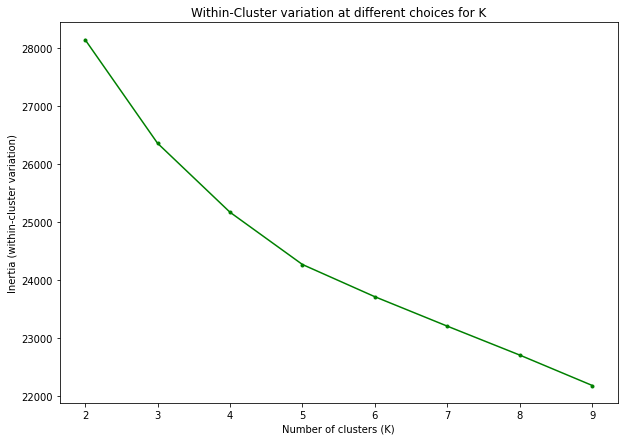

In [ ]:
#code adapted from lab notebook (lecture 8)
inertias = []

#get inertias for each k, create plot
for i in range(2,10):
    fit = KMeans(n_clusters=i, init='random', n_init=46, random_state=109).fit(sample_X)
    inertias.append(fit.inertia_)

plt.figure(figsize=(10,7))
plt.plot(range(2,10), inertias, 'g.-')
plt.xticks(np.arange(2,10,1))
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (within-cluster variation)')
plt.title('Within-Cluster variation at different choices for K')
plt.show()

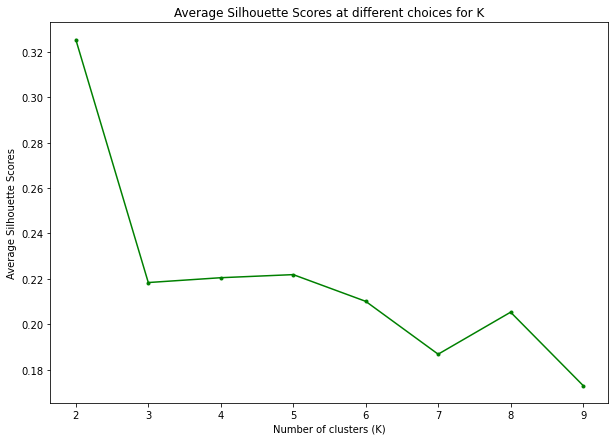

In [ ]:
## Clusters based on sillhoutte score

#code adapted from lab notebook (lecture 8)
sils = []

#get silhouettes for each k, create plot
for i in range(2,10):
    fit = KMeans(n_clusters=i, init='random', n_init=46, random_state=109).fit(sample_X)
    sils.append(silhouette_score(sample_X, fit.labels_))

plt.figure(figsize=(10,7))
plt.plot(range(2,10), sils, 'g.-')
plt.xticks(np.arange(2,10,1))
plt.xlabel('Number of clusters (K)')
plt.ylabel('Average Silhouette Scores')
plt.title('Average Silhouette Scores at different choices for K')
plt.show()

In [ ]:
!pip install gap-stat
from gap_statistic import OptimalK

Optimal K (# of clusters):  8


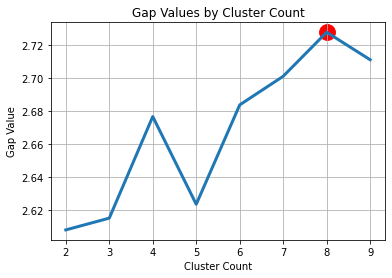

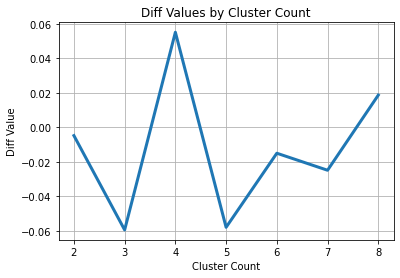

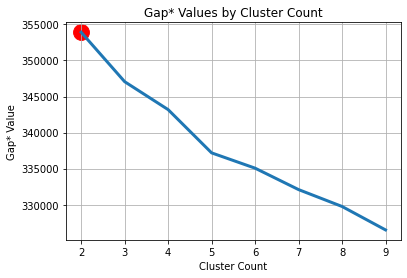

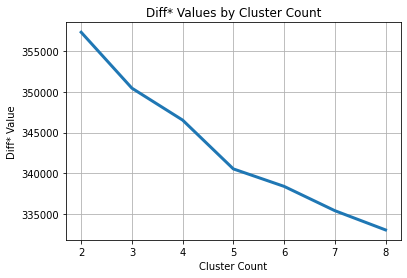

In [ ]:
## Ideal number of clusters using gap statistic
gap_fit = OptimalK()
k = gap_fit(sample_X, n_refs=50, cluster_array=np.arange(2, 10))
print('Optimal K (# of clusters): ', k)

#Plot
gap_fit.plot_results()

Across all metrics, the optimatl number of clusters is 2. Two clusters maximizes the Gap* statistic. K = 2 also provides the maximum silhoutte value. Finally, there is no clear "elbow" in the elbow plot, suggesting that K = 2 is a reasonable choice.

## Section 8: Fitting Our Full Model and Interpreting Its Clusters

Below, we fit the full model on the full Hebrew Bible, using our optimal number of clusters (K = 2). We then visualize the separation between clusters using both a silhoutte plot and a PCA plot.

In [ ]:
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example we 
    # will set a limit
    ax1.set_xlim([-0.2, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    # axes will be first 2 PCA components
    
    pca = PCA(n_components=2).fit(X)
    X_pca = pca.transform(X) 
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X_pca[:, 0]
    ys = X_pca[:, 1]    

    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters (transform to PCA space for plotting)
    centers = pca.transform(clusterer.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 2, the average silhouette_score is 0.3253844137728294.


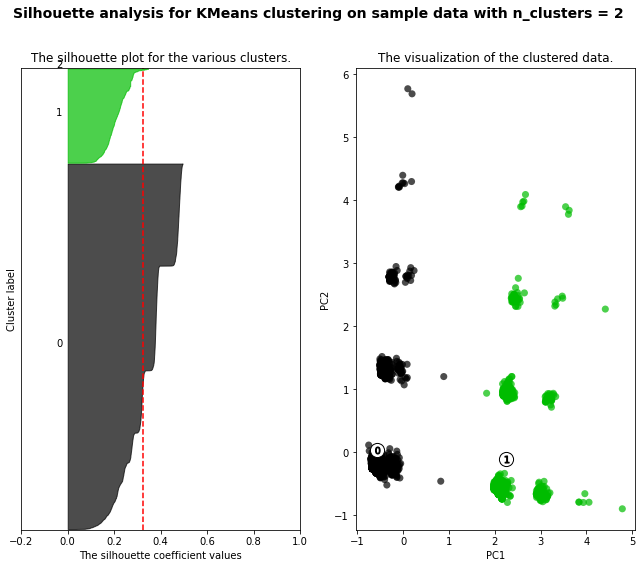

In [ ]:
#Sillhoutte plot and score
silplot(vec_to_cluster, first_five_data['K_2'].values, bible_cluster_2)

According to the principal components decomposition, there appears to be more distinct clusters than just two. Specifically, our model appears to divide about 9 distinct clusters into two sets. Let's see what happens when we fit a K = 9 model, in an attempt to capture these more granular clusters:

For n_clusters = 9, the average silhouette_score is 0.21392088596191586.


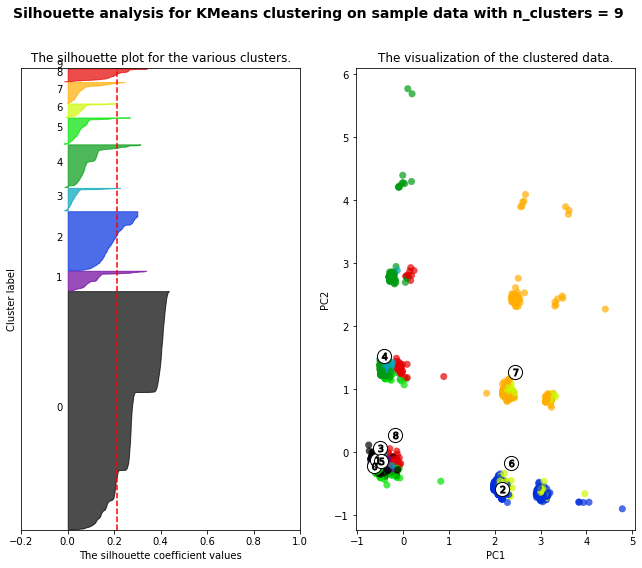

In [ ]:
#Sillhoutte plot and score
silplot(vec_to_cluster, first_five_data['K_9'].values, bible_cluster_9)

We see that the cluster centroids do not correspond to the clusters that we can see visually in the PCA plot. This produces a lower sillhoutte score overall. One reason for this result in our use of manual weights, which makes our vector of features not quite normalized and potentially unbalanced along the principal components.

So, we will continue with the two clusters, knowing that our KMeans algorithm is better capturing some variation at a broader level (and that it is currently not capable of capturing this more granular variation along the principal components).

**Visualizing and Interpreting the Verses Closest to Our Two Centroids**

Below, we calculate the Euclidean distance between each verse and its clustered centroid. We then print out the closest 5 verses to each of the two centroids, in order to interpret what sorts of semantic and stylistic differences our model is capturing in its clustering.

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
##Get Euclidean Distances from clusters
distances_k2 = []
for i in range(len(first_five_data)):
  
  row_of_features = np.array(first_five_data.features[i]).reshape(1, -1)
  cluster = first_five_data.K_2[i]
  distances_k2.append(euclidean_distances(row_of_features, np.array(bible_cluster_2.cluster_centers_[cluster]).reshape(1,-1))[0][0])

first_five_data['dist_2'] = distances_k2

In [ ]:
## Put transliterated and translated verses on dataframe
first_five_data['english'] = english_data['all_text'].values[0:5853]

In [ ]:
##Print versus with lowest distance from both clusters
cluster_0_df = first_five_data.loc[first_five_data['K_2'] == 0]
cluster_1_df = first_five_data.loc[first_five_data['K_2'] == 1]
lowest_cluster_0 = cluster_0_df.all_text.values[np.argsort(cluster_0_df.dist_2.values)]
lowest_cluster_1 = cluster_1_df.all_text.values[np.argsort(cluster_1_df.dist_2.values)]
lowest_cluster_0_translate = cluster_0_df.english.values[np.argsort(cluster_0_df.dist_2.values)]
lowest_cluster_1_translate = cluster_1_df.english.values[np.argsort(cluster_1_df.dist_2.values)]

In [ ]:
print("Verses with Lowest Euclidean Distances from Cluster 0 Centroid")
print(lowest_cluster_0)

Verses with Lowest Euclidean Distances from Cluster 0 Centroid
['Gen 36:22 ויהיו בני־לוטן חרי והימם ואחות לוטן תמנע'
 'Gen 24:20 ותמהר ותער כדה אל־השקת ותרץ עוד אל־הבאר לשאב ותשאב לכל־גמליו'
 'Num 24:24 וצים מיד כתים וענו אשור וענו־עבר וגם־הוא עדי אבד' ...
 'Gen 14:9 את כדרלעמר מלך עילם ותדעל מלך גוים ואמרפל מלך שנער ואריוך מלך אלסר ארבעה מלכים את־החמשה'
 'Num 11:22 הצאן ובקר ישחט להם ומצא להם אם את־כל־דגי הים יאסף להם ומצא להם פ'
 'Lev 8:2 קח את־אהרן ואת־בניו אתו ואת הבגדים ואת שמן המשחה ואת פר החטאת ואת שני האילים ואת סל המצות']


In [ ]:
print("Verses with Lowest Euclidean Distances from Cluster 1 Centroid")
print(lowest_cluster_1)

Verses with Lowest Euclidean Distances from Cluster 1 Centroid
['Gen 29:31 וירא יהוה כי־שנואה לאה ויפתח את־רחמה ורחל עקרה'
 'Lev 2:10 והנותרת מן־המנחה לאהרן ולבניו קדש קדשים מאשי יהוה'
 'Gen 18:1 וירא אליו יהוה באלני ממרא והוא ישב פתח־האהל כחם היום' ...
 'Deu 4:40 ושמרת את־חקיו ואת־מצותיו אשר אנכי מצוך היום אשר ייטב לך ולבניך אחריך ולמען תאריך ימים על־האדמה אשר יהוה אלהיך נתן לך כל־הימים פ'
 'Deu 28:52 והצר לך בכל־שעריך עד רדת חמתיך הגבהות והבצרות אשר אתה בטח בהן בכל־ארצך והצר לך בכל־שעריך בכל־ארצך אשר נתן יהוה אלהיך לך'
 'Gen 24:27 ויאמר ברוך יהוה אלהי אדני אברהם אשר לא־עזב חסדו ואמתו מעם אדני אנכי בדרך נחני יהוה בית אחי אדני']


In [ ]:
print("Translated Verses with Lowest Euclidean Distances from Cluster 0 Centroid")
print(lowest_cluster_0_translate)

Translated Verses with Lowest Euclidean Distances from Cluster 0 Centroid
["Gen 36:22 And the children of Lotan were Hori and Hemam; and Lotan's sister [was] Timna."
 'Gen 24:20 And she hasted, and emptied her pitcher into the trough, and ran again unto the well to draw [water], and drew for all his camels.'
 'Num 24:24 And ships [shall come] from the coast of Chittim, and shall afflict Asshur, and shall afflict Eber, and he also shall perish for ever.'
 ...
 'Gen 14:9 With Chedorlaomer the king of Elam, and with Tidal king of nations, and Amraphel king of Shinar, and Arioch king of Ellasar; four kings with five.'
 'Num 11:22 Shall the flocks and the herds be slain for them, to suffice them? or shall all the fish of the sea be gathered together for them, to suffice them?'
 'Lev 8:2 Take Aaron and his sons with him, and the garments, and the anointing oil, and a bullock for the sin offering, and two rams, and a basket of unleavened bread;']


In [ ]:
print("Translated Verses with Lowest Euclidean Distances from Cluster 0 Centroid")
print(lowest_cluster_1_translate)

Translated Verses with Lowest Euclidean Distances from Cluster 0 Centroid
['Gen 29:31 And when the LORD saw that Leah [was] hated, he opened her womb: but Rachel [was] barren.'
 "Lev 2:10 And that which is left of the meat offering [shall be] Aaron's and his sons': [it is] a thing most holy of the offerings of the LORD made by fire."
 'Gen 18:1 And the LORD appeared unto him in the plains of Mamre: and he sat in the tent door in the heat of the day;'
 ...
 'Deu 4:41 Then Moses severed three cities on this side Jordan toward the sunrising;'
 'Deu 28:53 And thou shalt eat the fruit of thine own body, the flesh of thy sons and of thy daughters, which the LORD thy God hath given thee, in the siege, and in the straitness, wherewith thine enemies shall distress thee:'
 "Gen 24:27 And he said, Blessed [be] the LORD God of my master Abraham, who hath not left destitute my master of his mercy and his truth: I [being] in the way, the LORD led me to the house of my master's brethren."]


Cluster 0 seems to have very repetitive and short syntax: "and this, and that, and that," "king of this, king of that, king of that," "she hasted, and empited, and ran, and drew,: etc. In addition, Cluster 0 is mostly about people who are not God.

Cluster 1 uses Yahwey (יהוה), which is one of the holiest names for the lord - so much so, that modern Jewish traditions forbid the reading of this word, often preferencing it for Adonai. In addition, Cluster 1 contains longer sentences, with more complex syntax.

This differentiation demonstrates that our model clearly is able to distinguish both style and meaning: short, choppy, repeated syntax about non-holy topics vs. longer flowing sentences about God. However, it's unclear whether this kind of distinguishing is the same thing as distinguishing authorship. For example, it could be that multiple authors write in short choppy sentences and multiple authors write in longer flowing sentences - so our model doesn't have enough clusters. It could also be that the same author tends to vary their syntax between short and simple sentences when discussing Earthly topics and longer sentecnes with complex structure when talking about Holy topics. So, our model may be predicting two authors for passages with a single author who varies their style.

## Section 9: Testing Accuracy: How Our Full Model Performs on Combined Texts

In [ ]:
##Remake combined texts, but now with full feature set information

# Ezekiel-Job Composite Text
ezekiel_job = hebrew_script_data.loc[(hebrew_script_data.book == 'Eze') | (hebrew_script_data.book == 'Job')]
ezekiel_job = ezekiel_job.sample(frac = 1)

# Isaiah-Proverbs Composite Text
isaiah_proverbs = hebrew_script_data.loc[(hebrew_script_data.book == 'Isa') | (hebrew_script_data.book == 'Pro')]
isaiah_proverbs = isaiah_proverbs.sample(frac = 1)

,all_text,label,book,text,Bert_probs_1,Bert_probs_2,verse_len,avg_word_len,std_word_len,common_word_vec,num_conjunctions,name_of_god,just_features,just_embedding,features
19062,Jer 2:29 למה תריבו אלי כלכם פשעתם בי נאם־יהוה,Jer 2:29,Prophets,למה תריבו אלי כלכם פשעתם בי נאם־יהוה,0.559479,0.474393,7,4.285714,1.829464,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,-1,"[-0.007117262498165171, -0.0019072550121785664...","[0.0087523665, 0.047369815, 0.008470431, 0.009...","[-0.007117262498165171, -0.0019072550121785664..."
18684,Isa 48:1 שמעו־זאת בית־יעקב הנקראים בשם ישראל ו...,Isa 48:1,Prophets,שמעו־זאת בית־יעקב הנקראים בשם ישראל וממי יהודה...,0.722720,0.331774,18,4.944444,1.715039,"[0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, ...",0,0,"[0.0, -0.00041030781585874563, -0.003627974878...","[0.012969649, -0.0065673855, 0.02999383, 0.000...","[0.0, -0.00041030781585874563, -0.003627974878..."
17003,Pro 19:9 עד שקרים לא ינקה ויפיח כזבים יאבד פ,Pro 19:9,Writings,עד שקרים לא ינקה ויפיח כזבים יאבד פ,0.617872,0.408763,8,3.500000,1.500000,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,-1,"[-0.00647023863469561, -0.003692770342728713, ...","[0.013340911, -0.014687033, 0.0113894185, -0.0...","[-0.00647023863469561, -0.003692770342728713, ..."
13455,Job 24:16 חתר בחשך בתים יומם חתמו־למו לא־ידעו אור,Job 24:1,Writings,חתר בחשך בתים יומם חתמו־למו לא־ידעו אור,0.539897,0.482547,7,4.714286,1.829464,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,-1,"[-0.007117262498165171, -0.0009333375591512135...","[-0.08620917, -0.014797979, -0.0042814165, -0....","[-0.007117262498165171, -0.0009333375591512135..."
20316,Jer 51:36 לכן כה אמר יהוה הנני־רב את־ריבך ונקמ...,Jer 51:3,Prophets,לכן כה אמר יהוה הנני־רב את־ריבך ונקמתי את־נקמת...,0.911907,0.120954,12,5.583333,1.977302,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,"[-0.0038821431808173665, 0.0010415506094875852...","[-0.008500806, 0.04143127, 0.008777306, 0.0303...","[-0.0038821431808173665, 0.0010415506094875852..."


Purity score for Ezekiel and Job Clustering:  0.665




[Text(0, 0.5, 'Verse Count'),
 Text(0.5, 0, 'Clusters'),
 Text(0.5, 1.0, 'Clusters when k=2, Full Model, Ezekiel and Job')]

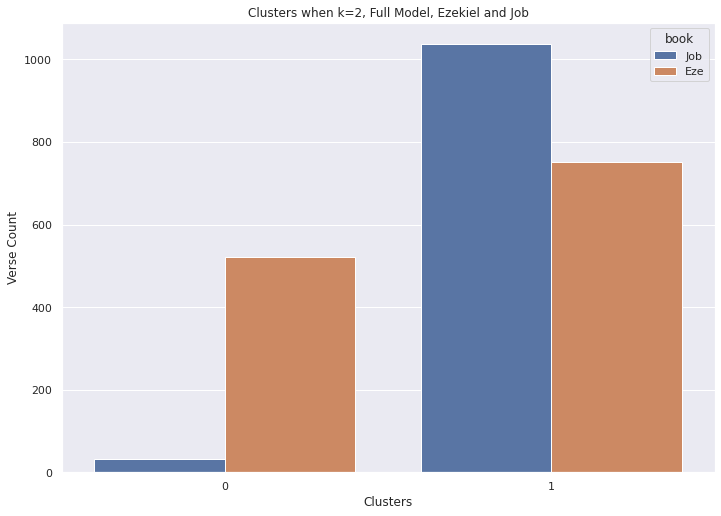

In [ ]:
## Clustering results for Ezekial Job

## Cluster by book
e_j_features = np.array([np.array(feat) for feat in ezekiel_job.features.values])
fitted_e_j = KMeans(n_clusters=2,n_init=46,random_state=109).fit(e_j_features)
ezekiel_job['final_clusters'] = fitted_e_j.labels_

#Print purity score
print('Purity score for Ezekiel and Job Clustering: ', round(purity_score(ezekiel_job['book'].values,ezekiel_job['final_clusters'].values), 3))
print('\n')
## Plot clustering by book
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=ezekiel_job, x="final_clusters", hue="book").set(title='Clusters when k=2, Full Model, Ezekiel and Job', xlabel='Clusters', ylabel='Verse Count')

The baseline model has a purity score for the Ezekiel and Job composite text of 0.543. The full model improves on that score, achieving 0.665 purity. Visually, we also see that the full model is able to create at least one mostly pure cluster: cluster 0 contains almost entirely verses from Ezekiel. By contrast, the baseline model had a mix of verses from both book in each cluster.

So, our full model definitely improves on the baseline in that its able to recognize some verses from Ezekiel as belonging to the same cluster, without combining with many verses from Job. We believe this improvement is due to the use of many more stylistic features as well as the BERT sentence embeddings in our full model. Because of these features, the full model is able to better distinguish the style and content of a prophet (Ezekiel) from the style and content of a more lyrical writing (Job).

Purity score for Isaiah and Proverbs:  0.595




[Text(0, 0.5, 'Verse Count'),
 Text(0.5, 0, 'Clusters'),
 Text(0.5, 1.0, 'Clusters when k=2, Full Model, Isiaha and Proverbs')]

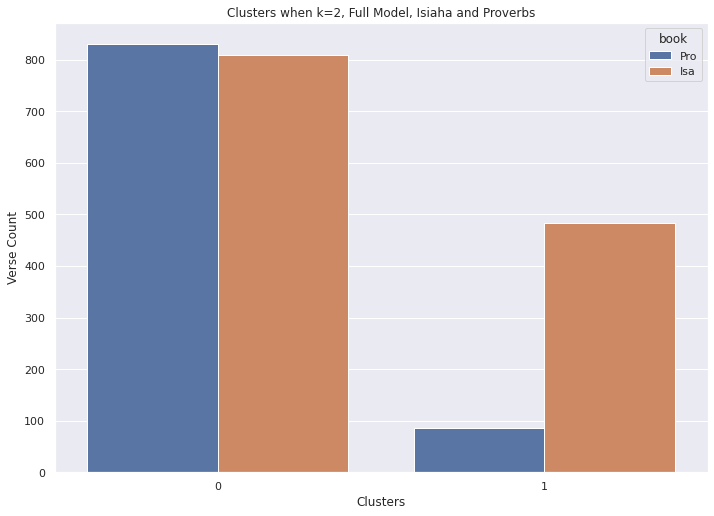

In [ ]:
## Clustering results for Isaiah and Proverbs

## Cluster by book
i_p_features = np.array([np.array(feat) for feat in isaiah_proverbs.features.values])
fitted_i_p = KMeans(n_clusters=2,n_init=46,random_state=109).fit(i_p_features)
isaiah_proverbs['final_clusters'] = fitted_i_p.labels_

#Print purity score
print('Purity score for Isaiah and Proverbs: ', round(purity_score(isaiah_proverbs['book'].values,isaiah_proverbs['final_clusters'].values), 3))
print('\n')
## Plot clustering by book
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=isaiah_proverbs, x="final_clusters", hue="book").set(title='Clusters when k=2, Full Model, Isiaha and Proverbs', xlabel='Clusters', ylabel='Verse Count')

Similarly to before, the full model definitely improves on baseline performance. The baseline model has a purity score for the Isiah and Proverbs composite text of 0.585. The full model improves on that score, achieving 0.595 purity. Visually, we also see that the full model is able to create at least one mostly pure cluster: cluster 1 contains almost entirely verses from Isiaiah. By contrast, the baseline model had a mix of verses from both book in each cluster.

So, our full model definitely improves on the baseline in that its able to recognize some verses from Isaiah as belonging to the same cluster, without combining with many verses from Proverbs. 

As befire, we believe this improvement is due to the use of many more stylistic features as well as the BERT sentence embeddings in our full model. Because of these features, the full model is able to better distinguish the style and content of a prophet (Isaiah) from the style and content of a more lyrical writing (Proverbs).

## Section 10: Final Authorship Delineations, on Full Hebrew Bible

**Finally, to see our final resutls, here are our model's final predictions on the first several chapters of Genesis**

Distribution of authors by book

In [ ]:
verse_english = first_five_data['english'].values[0:50]
verse_hebrew = first_five_data['text'].values[0:50]
author = first_five_data['K_2'].values[0:50]

genesis_results = pd.DataFrame(list(zip(verse_english, verse_hebrew, author)),
               columns =['Verse (English)', 'Verse (Hebrew)', 'Author (0 or 1'])

genesis_results.head(50)

,Verse (English),Verse (Hebrew),Author (0 or 1
0,Gen 1:1 In the beginning God created the heave...,בראשית ברא אלהים את השמים ואת הארץ,0
1,"Gen 1:2 And the earth was without form, and vo...",והארץ היתה תהו ובהו וחשך על־פני תהום ורוח אלהי...,0
2,"Gen 1:3 And God said, Let there be light: and ...",ויאמר אלהים יהי אור ויהי־אור,0
3,"Gen 1:4 And God saw the light, that [it was] g...",וירא אלהים את־האור כי־טוב ויבדל אלהים בין האור...,0
4,"Gen 1:5 And God called the light Day, and the ...",ויקרא אלהים לאור יום ולחשך קרא לילה ויהי־ערב ו...,0
5,"Gen 1:6 And God said, Let there be a firmament...",ויאמר אלהים יהי רקיע בתוך המים ויהי מבדיל בין ...,0
6,"Gen 1:7 And God made the firmament, and divide...",ויעש אלהים את־הרקיע ויבדל בין המים אשר מתחת לר...,0
7,Gen 1:8 And God called the firmament Heaven. A...,ויקרא אלהים לרקיע שמים ויהי־ערב ויהי־בקר יום ש...,0
8,"Gen 1:9 And God said, Let the waters under the...",ויאמר אלהים יקוו המים מתחת השמים אל־מקום אחד ו...,0
9,Gen 1:10 And God called the dry [land] Earth; ...,ויקרא אלהים ליבשה ארץ ולמקוה המים קרא ימים ויר...,0


We also find the number of distributions attributed to each author (author 0 and author 1). As you can see, our model found that almost 80% of verses would be attributed to author 0:

In [ ]:
## Total Distribution of Authors
print('Final Distribution of Authors: ')
print(pd.value_counts(first_five_data.K_2))

print('\nPercent from each Author: ')
print(round(pd.value_counts(first_five_data.K_2)/len(first_five_data) * 100, 1))

Final Distribution of Authors: 
0    4654
1    1199
Name: K_2, dtype: int64

Percent from each Author: 
0    79.5
1    20.5
Name: K_2, dtype: float64


We also find the distribution of author attributions by verses in different books. We can see that a similar split of mostly author 0 across all the books. However, author 1 has a relatively high proportion of verses in Deuteronomy:

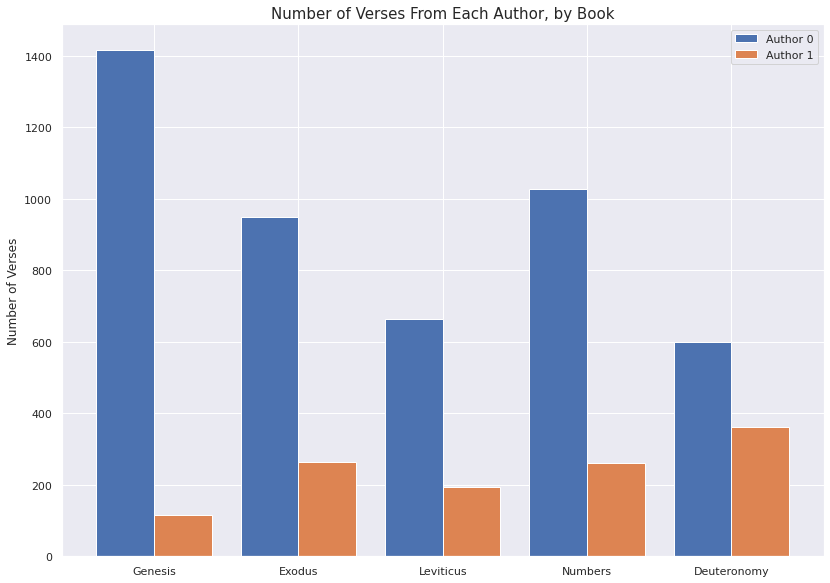

In [ ]:
##Show distribution of authors per book
#based on matplotlib documenation: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
labels = ['Genesis','Exodus','Leviticus','Numbers','Deuteronomy']
author_0 = []
author_1 = []

list_of_books = ['Gen','Exo','Lev','Num','Deu']
for i, book in enumerate(list_of_books):
    book_df = first_five_data[first_five_data['book'] == book]
    author_0.append(pd.value_counts(book_df.K_2)[0])
    author_1.append(pd.value_counts(book_df.K_2)[1])

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, author_0, width, label='Author 0')
rects2 = ax.bar(x + width/2, author_1, width, label='Author 1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Verses')
ax.set_title('Number of Verses From Each Author, by Book', size = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

If our model truly picks up differences in styles, this shows us that Genesis is more stylistically consistent than later books, such as Deuternonomy.

In [ ]:
# ## Save our results
# first_five_data.to_csv('drive/MyDrive/final_predictions.csv')
# ezekiel_job.to_csv('drive/MyDrive/ezekial_job_predictions.csv')

**Finally, we get our clusters on the entire Hebrew Bible and store for future use**

In [ ]:
## Final value counts for entire corpus
features_total = np.array([np.array(feat) for feat in hebrew_script_data.features.values])
bible_cluster_full_text = KMeans(n_clusters=2,n_init=46,random_state=109).fit(features_total)

## Store clusters in dataframe
hebrew_script_data['K_2'] = bible_cluster_full_text.labels_

In [ ]:
verse_english = hebrew_script_data['english'].values[0:50]
verse_hebrew = hebrew_script_data['text'].values[0:50]
author = hebrew_script_data['K_2'].values[0:50]

full_results = pd.DataFrame(list(zip(verse_english, verse_hebrew, author)),
               columns =['Verse (English)', 'Verse (Hebrew)', 'Author (0 or 1'])

# # full_results.to_csv('drive/MyDrive/final_predictions_full.csv')

Final distribution of verses from each author in entire Hebrew Bible:

In [ ]:
## Get final distribution of author verse counts
print('Final Distribution of Authors: ')
print(pd.value_counts(hebrew_script_data.K_2))

print('\nPercent from each Author: ')
print(round(pd.value_counts(hebrew_script_data.K_2)/len(hebrew_script_data) * 100, 1))

Final Distribution of Authors: 
0    14383
1     8830
Name: K_2, dtype: int64

Percent from each Author: 
0    62.0
1    38.0
Name: K_2, dtype: float64


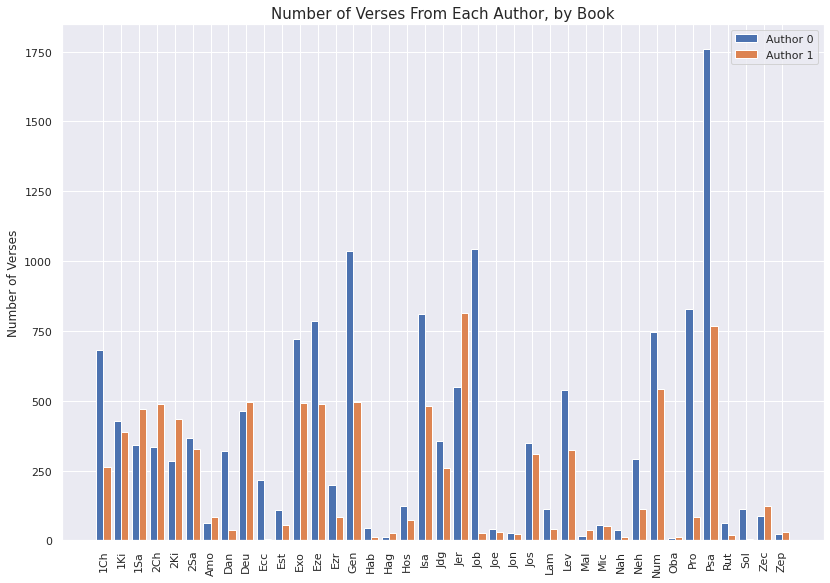

In [ ]:
##Show distribution of authors per book
#based on matplotlib documenation: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
labels = list(np.unique(hebrew_script_data['book'].values))
author_0 = []
author_1 = []

for i, book in enumerate(labels):
    book_df = hebrew_script_data[hebrew_script_data['book'] == book]
    author_0.append(pd.value_counts(book_df.K_2)[0])
    author_1.append(pd.value_counts(book_df.K_2)[1])

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, author_0, width, label='Author 0')
rects2 = ax.bar(x + width/2, author_1, width, label='Author 1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Verses')
ax.set_title('Number of Verses From Each Author, by Book', size = 15)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 90)
ax.legend()

fig.tight_layout()

plt.show()

Although we saw Author 0 was pretty dominant when just looking at Genesis, Exodus, Leviticus, and Deuteronomy, We can see that Author 1 completes a higher share of versus in other books - including more than Author 0 in some books.

## Section 11: Discussion and Future Work

**Conclusion**

There are a number of overall benefits to our approach compared to existing literature. Firstly, Koppel's seminal approach does not scale well past k=2. Our approach, on the other hand has the potential to scale to k=n where n is the number of stylistically different books the fine-tuned BERT classifier is trained on. Secondly, our approach does not assume supervised labels and therefore is not constrained by existing scholarly views on the topic.

There are also limitations to our approach. Firstly, even if our model extracts sylistic features from the text to create a representation, it is not clear whether different styles necessarily mean that books come from different authors. Indeed, though we have attempted to disentangle the extent to which our model distinguishes between different styles by creating a composite texts from two genres and by inspecting the sentences close to the centroids of our clusters, we cannot fully verify that our model is picking up style in a more principled way. 

**Next Steps**

There are several ways that we could improve on our approach. Firstly, training our classifier on many varied translations of the Bible would provide a more sophisticated classification score that might be able to decipher between multiple styles, rather then two. Secondly, extracting the embeddings from this model and using those embeddings to cluster all the books of the Bible might provide a set of embeddings more tailored to style (compared to the SBert sentence embeddings) on which to cluster.  This should be tested to see whether this approach improves on the sentence Bert embeddings.

In addition, we manually set the weights for our vector of features. In future work, these weights could be learned through cross validiation with purity as the outcome on composite texts. Finally, we could use GANs or Autoencoders to reconstruct and vary style, which would help a discriminator better learn to disntiguish between authorship styles.

**Citations**

Aldebei et al. (2018) ‘SUDMAD: Sequential and Unsupervised Decomposition of a Multi-Author Document Based on a Hidden Markov Model’, JOURNAL OF THE ASSOCIATION FOR INFORMATION SCIENCE AND TECHNOLOGY, 69(2):201–214. p.202

Koppel, A. et. al. (2011) 'Unsupervised Decomposition of a Document into Authorial Components', Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics, pages 1356–1364.
